_________________________________________________________________________

**Teste Técnico** - Churn em companias telefonicas <br> <br>
Rafael Henrique Martello

_________________________________________________________________________

# Bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Pré-processamento
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

# Modelos
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

# Hyperparametros
import optuna

# Metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import shap

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve











<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Carregar dados

In [2]:
# Carregando dados:

df = pd.read_excel('Data/Customer-Churn.xlsx')

In [3]:
df.shape

(7043, 21)

# Verificações iniciais

### 1 - Verificar IDs duplicados

In [4]:
df['customerID'].duplicated().sum()

0

### 2 - Verificar Nulos

In [5]:
def Nulos(df):
    '''
    Função para verificar nulos no dataset

    Input -> df: DataFrame a ser analisado
    Output -> dataset: tabela com colunas que contem nulos
    '''
    lista_null=[]
    for col in df.columns:
        if df[col].isna().sum()>0:
            lista_null.append([col, df[col].isna().sum(),round(100*df[col].isna().sum()/df[col].shape[0],2)])
    
    return pd.DataFrame(lista_null, columns=['Coluna', 'Linhas', '%'])

Nulos(df)

Coluna  Linhas    %
0  TotalCharges      11 0.16

### 3 - Verificar Categóricas

In [6]:
df.select_dtypes('object').nunique()

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
dtype: int64

# Preparação 

### 1 - Codificar categoricas

In [7]:
categorical_columns = df.drop('customerID', axis=1).select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [8]:
df_encoded.columns

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (

### 2 - Verificando variáveis numéricas

In [9]:
df.select_dtypes('number')

SeniorCitizen  tenure  MonthlyCharges  TotalCharges
0                 0      72          118.75       8672.45
1                 0      71          118.65       8477.60
2                 0      68          118.60       7990.05
3                 0      61          118.60       7365.70
4                 0      67          118.35       7804.15
...             ...     ...             ...           ...
7038              0      53           18.70       1005.70
7039              0      25           18.70        383.65
7040              0      36           18.55        689.00
7041              0      59           18.40       1057.85
7042              0      28           18.25        534.70

[7043 rows x 4 columns]

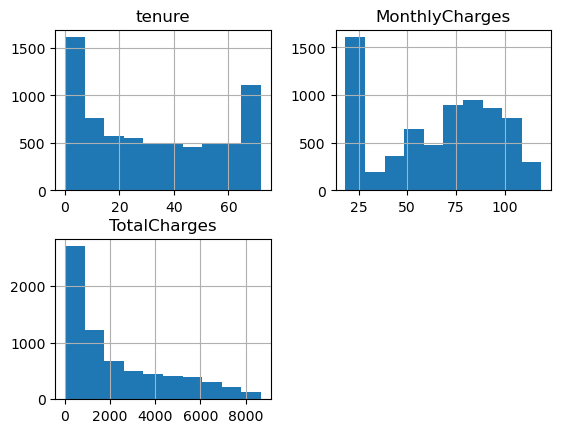

In [10]:
# Observação rápida das distribuições 

df[['tenure', 'MonthlyCharges', 'TotalCharges']].hist();

### 3 - Removendo Outliers


In [11]:

def Outliers(data, lista_features):
    '''
    Detecção de Outliers usando IQR
    '''
    # Calcular o IQR para cada coluna numérica
    data = data[lista_features]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Definir limites para detecção de outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remover outliers
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

    # Verificar o tamanho dos dados antes e depois da remoção de outliers
    print("Tamanho do DataFrame original:", data.shape)
    print("Tamanho do DataFrame após remoção de outliers:", data_clean.shape)

    if data.shape[0]!=data_clean.shape[0]:
        return data_clean



Outliers(df_encoded, ['tenure', 'MonthlyCharges', 'TotalCharges'])

#O método de IQR não identificou nenhum outlier, então podemos continuar 


Tamanho do DataFrame original: (7043, 3)
Tamanho do DataFrame após remoção de outliers: (7043, 3)


### 4 - Tratar nulos

In [12]:

# se estivessemos trabalhando com dados mensais seria mais interessante fazer o 
# preenchimento de nulos depois de dividir treino e teste para evitar contaminações
# mas como são dados unicos por ID e atemporais podemos tratar os nulos antes


# Temos duas abordagens possíveis remover as linhas com valores nulos (corresponde apenas a 0.16% da base ou 11 linhas), 
# ou usar uma tecnina para preencher (imputar médiamediana [mais robusto para tendencia central da distribuição dos dados] ou métodos como KNN inputer)


In [13]:
df_encoded.shape

(7043, 42)

In [14]:
# para essa situação vou optar por remover as linhas com valores nulos:

df_encoded.dropna(inplace=True)

In [15]:
df_encoded.shape

(7032, 42)

### 5 - Divisão Treino e teste

In [16]:
X = df_encoded.drop(['Churn_Yes'], axis=1)
y = df_encoded['Churn_Yes']

In [17]:
X.shape

(7032, 41)

In [18]:
# usando stratify para manter a proporção de churn
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, X.index, test_size=0.33, random_state=42, stratify=y)

In [19]:
ID_treino = X_train['customerID'].copy()
ID_teste = X_test['customerID'].copy()

X_train.drop('customerID', axis=1, inplace=True)
X_test.drop('customerID', axis=1, inplace=True)

# Análise exploratória

In [20]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [21]:
df.select_dtypes('object')

customerID  gender Partner Dependents PhoneService MultipleLines   
0     7569-NMZYQ  Female     Yes        Yes          Yes           Yes  \
1     8984-HPEMB  Female      No         No          Yes           Yes   
2     5989-AXPUC  Female     Yes         No          Yes           Yes   
3     5734-EJKXG  Female      No         No          Yes           Yes   
4     8199-ZLLSA    Male      No         No          Yes           Yes   
...          ...     ...     ...        ...          ...           ...   
7038  0621-CXBKL  Female      No         No          Yes            No   
7039  9945-PSVIP  Female     Yes        Yes          Yes            No   
7040  0827-ITJPH    Male      No         No          Yes            No   
7041  9764-REAFF  Female     Yes         No          Yes            No   
7042  6823-SIDFQ    Male      No         No          Yes            No   

     InternetService       OnlineSecurity         OnlineBackup   
0        Fiber optic                  Yes                  Yes  \
1        Fiber optic                  Yes                  Yes   
2        Fiber optic                  Yes                  Yes   
3        Fiber optic                  Yes                  Yes   
4        Fiber optic                  Yes                  Yes   
...              ...                  ...                  ...   
7038              No  No internet service  No internet service   
7039              No  No internet service  No internet service   
7040              No  No internet service  No internet service   
7041              No  No internet service  No internet service   
7042              No  No internet service  No internet service   

         DeviceProtection          TechSupport          StreamingTV   
0                     Yes                  Yes                  Yes  \
1                     Yes                  Yes                  Yes   
2                     Yes                  Yes                  Yes   
3                     Yes                  Yes                  Yes   
4                     Yes                  Yes                  Yes   
...                   ...                  ...                  ...   
7038  No internet service  No internet service  No internet service   
7039  No internet service  No internet service  No internet service   
7040  No internet service  No internet service  No internet service   
7041  No internet service  No internet service  No internet service   
7042  No internet service  No internet service  No internet service   

          StreamingMovies  Contract PaperlessBilling   
0                     Yes  Two year              Yes  \
1                     Yes  Two year              Yes   
2                     Yes  Two year               No   
3                     Yes  One year              Yes   
4                     Yes  One year              Yes   
...                   ...       ...              ...   
7038  No internet service  Two year               No   
7039  No internet service  Two year              Yes   
7040  No internet service  Two year              Yes   
7041  No internet service  Two year               No   
7042  No internet service  One year               No   

                  PaymentMethod Churn  
0     Bank transfer (automatic)    No  
1              Electronic check    No  
2                  Mailed check    No  
3              Electronic check    No  
4     Bank transfer (automatic)   Yes  
...                         ...   ...  
7038               Mailed check    No  
7039               Mailed check    No  
7040    Credit card (automatic)    No  
7041  Bank transfer (automatic)    No  
7042    Credit card (automatic)    No  

[7043 rows x 17 columns]

### 1 - Gráficos comparativos 

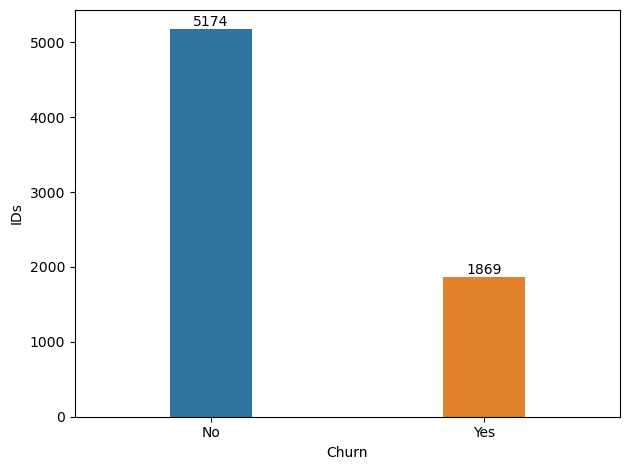

In [22]:
fig, ax = plt.subplots()
sns.countplot(x='Churn', data=df,  ax=ax, width=0.3)
ax.bar_label(ax.containers[-1], fmt='%.0f',)
plt.xlabel('Churn')
plt.ylabel('IDs')
plt.tight_layout()  # Ajusta a disposição dos elementos para evitar sobreposição
#plt.savefig(f'../reports/resultados/{pasta}/feature_importance_{mes_prod}.png', dpi =300, transparent = True, bbox_inches='tight')
plt.show()

In [23]:
df.Churn.value_counts(normalize=True)

Churn
No    0.73
Yes   0.27
Name: proportion, dtype: float64

In [24]:
# avaliando variáveis demograficas:
for i in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    print(i)
    display((df.groupby(i)['Churn'].count()/df.shape[0]).reset_index())
    print('___')

gender


gender  Churn
0  Female   0.50
1    Male   0.50

___
SeniorCitizen


SeniorCitizen  Churn
0              0   0.84
1              1   0.16

___
Partner


Partner  Churn
0      No   0.52
1     Yes   0.48

___
Dependents


Dependents  Churn
0         No   0.70
1        Yes   0.30

___


In [25]:
# avaliando variáveis demograficas:

for i in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    print(i)
    display(df.groupby(i)['Churn'].value_counts(normalize=True).reset_index())
    print('___')



gender


gender Churn  proportion
0  Female    No        0.73
1  Female   Yes        0.27
2    Male    No        0.74
3    Male   Yes        0.26

___
SeniorCitizen


SeniorCitizen Churn  proportion
0              0    No        0.76
1              0   Yes        0.24
2              1    No        0.58
3              1   Yes        0.42

___
Partner


Partner Churn  proportion
0      No    No        0.67
1      No   Yes        0.33
2     Yes    No        0.80
3     Yes   Yes        0.20

___
Dependents


Dependents Churn  proportion
0         No    No        0.69
1         No   Yes        0.31
2        Yes    No        0.85
3        Yes   Yes        0.15

___


In [26]:
# Avaliando variáveis de serviço

for i in df.drop(['Churn', 'customerID', 'tenure','MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], axis=1).columns:
    print(i)
    display((df.groupby(i)['Churn'].count()/df.shape[0]).reset_index())
    print('___')


PhoneService


PhoneService  Churn
0           No   0.10
1          Yes   0.90

___
MultipleLines


MultipleLines  Churn
0                No   0.48
1  No phone service   0.10
2               Yes   0.42

___
InternetService


InternetService  Churn
0             DSL   0.34
1     Fiber optic   0.44
2              No   0.22

___
OnlineSecurity


OnlineSecurity  Churn
0                   No   0.50
1  No internet service   0.22
2                  Yes   0.29

___
OnlineBackup


OnlineBackup  Churn
0                   No   0.44
1  No internet service   0.22
2                  Yes   0.34

___
DeviceProtection


DeviceProtection  Churn
0                   No   0.44
1  No internet service   0.22
2                  Yes   0.34

___
TechSupport


TechSupport  Churn
0                   No   0.49
1  No internet service   0.22
2                  Yes   0.29

___
StreamingTV


StreamingTV  Churn
0                   No   0.40
1  No internet service   0.22
2                  Yes   0.38

___
StreamingMovies


StreamingMovies  Churn
0                   No   0.40
1  No internet service   0.22
2                  Yes   0.39

___
Contract


Contract  Churn
0  Month-to-month   0.55
1        One year   0.21
2        Two year   0.24

___
PaperlessBilling


PaperlessBilling  Churn
0               No   0.41
1              Yes   0.59

___
PaymentMethod


PaymentMethod  Churn
0  Bank transfer (automatic)   0.22
1    Credit card (automatic)   0.22
2           Electronic check   0.34
3               Mailed check   0.23

___


In [27]:

for i in df.drop(['Churn','customerID', 'tenure','MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], axis=1).columns:
    print(i)
    display(df.groupby(i)['Churn'].value_counts(normalize=True).reset_index())
    print('___')

PhoneService


PhoneService Churn  proportion
0           No    No        0.75
1           No   Yes        0.25
2          Yes    No        0.73
3          Yes   Yes        0.27

___
MultipleLines


MultipleLines Churn  proportion
0                No    No        0.75
1                No   Yes        0.25
2  No phone service    No        0.75
3  No phone service   Yes        0.25
4               Yes    No        0.71
5               Yes   Yes        0.29

___
InternetService


InternetService Churn  proportion
0             DSL    No        0.81
1             DSL   Yes        0.19
2     Fiber optic    No        0.58
3     Fiber optic   Yes        0.42
4              No    No        0.93
5              No   Yes        0.07

___
OnlineSecurity


OnlineSecurity Churn  proportion
0                   No    No        0.58
1                   No   Yes        0.42
2  No internet service    No        0.93
3  No internet service   Yes        0.07
4                  Yes    No        0.85
5                  Yes   Yes        0.15

___
OnlineBackup


OnlineBackup Churn  proportion
0                   No    No        0.60
1                   No   Yes        0.40
2  No internet service    No        0.93
3  No internet service   Yes        0.07
4                  Yes    No        0.78
5                  Yes   Yes        0.22

___
DeviceProtection


DeviceProtection Churn  proportion
0                   No    No        0.61
1                   No   Yes        0.39
2  No internet service    No        0.93
3  No internet service   Yes        0.07
4                  Yes    No        0.77
5                  Yes   Yes        0.23

___
TechSupport


TechSupport Churn  proportion
0                   No    No        0.58
1                   No   Yes        0.42
2  No internet service    No        0.93
3  No internet service   Yes        0.07
4                  Yes    No        0.85
5                  Yes   Yes        0.15

___
StreamingTV


StreamingTV Churn  proportion
0                   No    No        0.66
1                   No   Yes        0.34
2  No internet service    No        0.93
3  No internet service   Yes        0.07
4                  Yes    No        0.70
5                  Yes   Yes        0.30

___
StreamingMovies


StreamingMovies Churn  proportion
0                   No    No        0.66
1                   No   Yes        0.34
2  No internet service    No        0.93
3  No internet service   Yes        0.07
4                  Yes    No        0.70
5                  Yes   Yes        0.30

___
Contract


Contract Churn  proportion
0  Month-to-month    No        0.57
1  Month-to-month   Yes        0.43
2        One year    No        0.89
3        One year   Yes        0.11
4        Two year    No        0.97
5        Two year   Yes        0.03

___
PaperlessBilling


PaperlessBilling Churn  proportion
0               No    No        0.84
1               No   Yes        0.16
2              Yes    No        0.66
3              Yes   Yes        0.34

___
PaymentMethod


PaymentMethod Churn  proportion
0  Bank transfer (automatic)    No        0.83
1  Bank transfer (automatic)   Yes        0.17
2    Credit card (automatic)    No        0.85
3    Credit card (automatic)   Yes        0.15
4           Electronic check    No        0.55
5           Electronic check   Yes        0.45
6               Mailed check    No        0.81
7               Mailed check   Yes        0.19

___


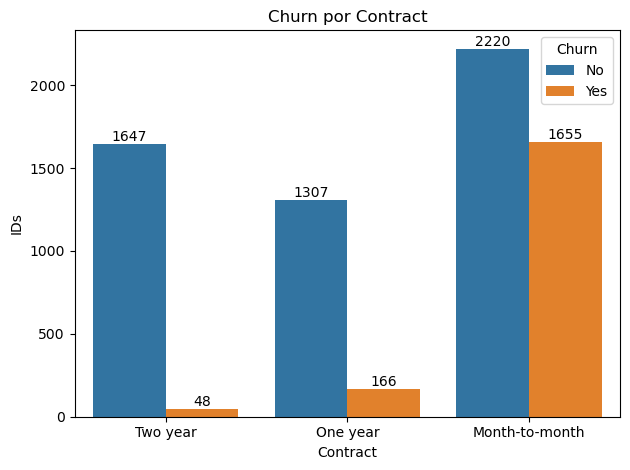

In [28]:
# Hipotese 1 - Clientes com contratos mais curtos têm maior probabilidade de churn.

fig, ax = plt.subplots()
sns.countplot(x='Contract', hue='Churn', data=df)

ax.bar_label(ax.containers[-1], fmt='%.0f')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.xlabel('Contract')
plt.ylabel('IDs')
plt.title('Churn por Contract')

plt.tight_layout()  # Ajusta a disposição dos elementos para evitar sobreposição
plt.show()

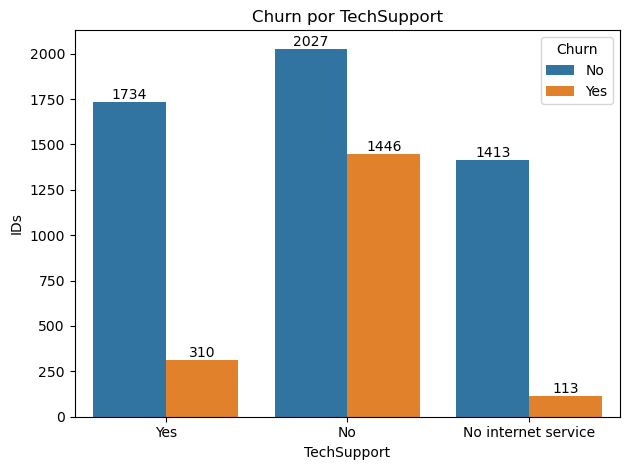

In [29]:
# Hipotese 2 - Pessoas que são mau atendidas tendem a ter churn maior

fig, ax = plt.subplots()
sns.countplot(x='TechSupport', hue='Churn', data=df)

ax.bar_label(ax.containers[-1], fmt='%.0f')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.xlabel('TechSupport')
plt.ylabel('IDs')
plt.title('Churn por TechSupport')

plt.tight_layout()  # Ajusta a disposição dos elementos para evitar sobreposição
plt.show()

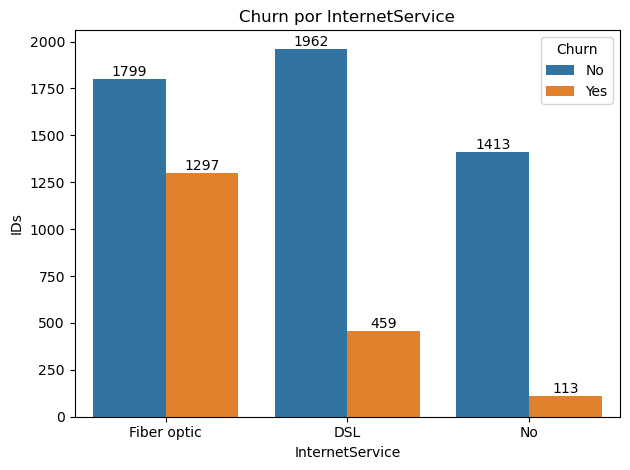

In [30]:
# Hipotese 3 - Planos de internet mais antigos ou de pior qualidade tendem a ter mais churn.


fig, ax = plt.subplots()
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn por InternetService')
ax.bar_label(ax.containers[-1], fmt='%.0f')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.xlabel('InternetService')
plt.ylabel('IDs')

plt.tight_layout()  # Ajusta a disposição dos elementos para evitar sobreposição
plt.show()

In [31]:
pd.DataFrame(df.groupby(['InternetService']).MonthlyCharges.mean()).reset_index()

InternetService  MonthlyCharges
0             DSL           58.10
1     Fiber optic           91.50
2              No           21.08

In [32]:
pd.DataFrame(df.groupby(['InternetService']).Contract.value_counts(normalize=True)).reset_index()

InternetService        Contract  proportion
0             DSL  Month-to-month        0.51
1             DSL        Two year        0.26
2             DSL        One year        0.24
3     Fiber optic  Month-to-month        0.69
4     Fiber optic        One year        0.17
5     Fiber optic        Two year        0.14
6              No        Two year        0.42
7              No  Month-to-month        0.34
8              No        One year        0.24

In [33]:
pd.DataFrame(df.groupby(['InternetService']).TechSupport.value_counts(normalize=True)).reset_index()

InternetService          TechSupport  proportion
0             DSL                   No        0.51
1             DSL                  Yes        0.49
2     Fiber optic                   No        0.72
3     Fiber optic                  Yes        0.28
4              No  No internet service        1.00

In [34]:
459/(459+1962)

0.1895910780669145

In [35]:
# Gráfico de barras para variáveis categóricas

plt.show()

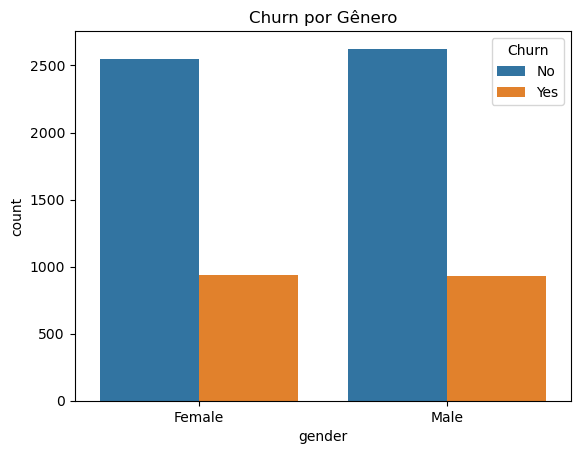

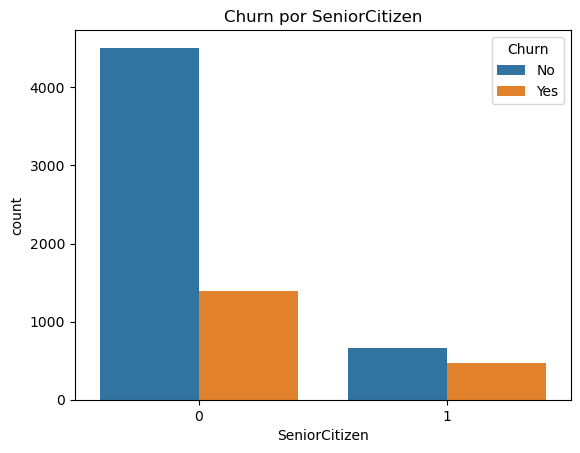

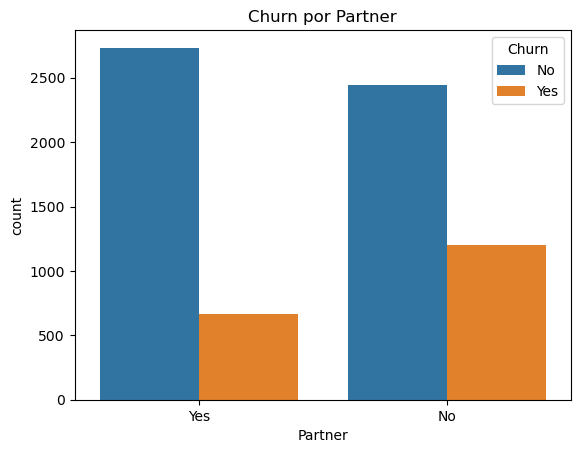

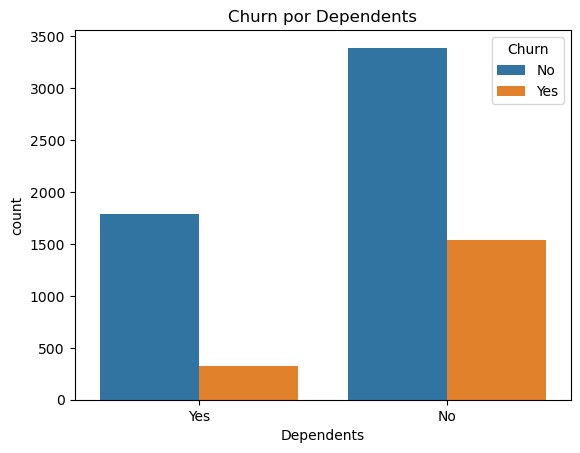

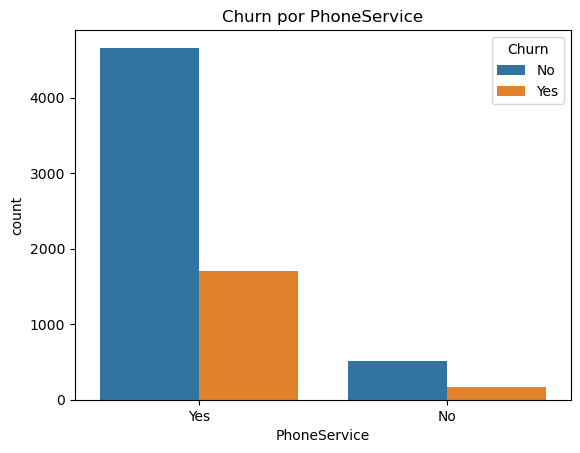

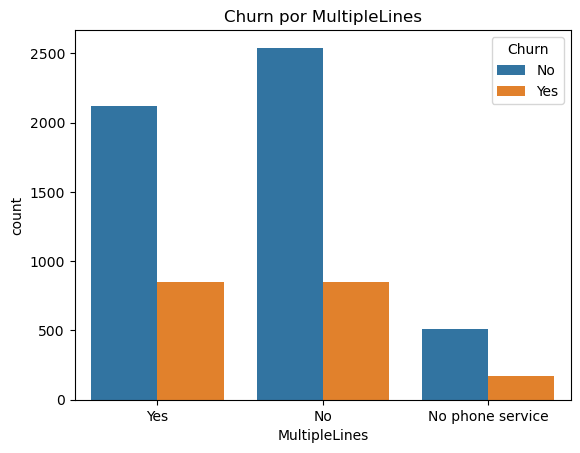

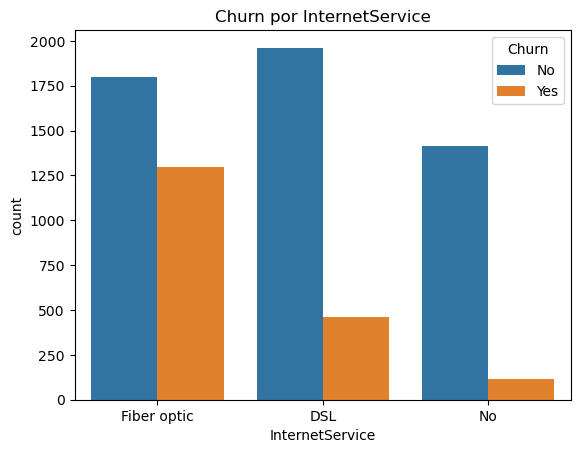

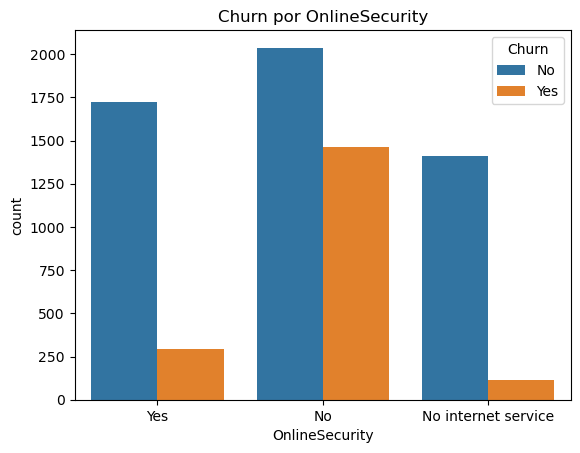

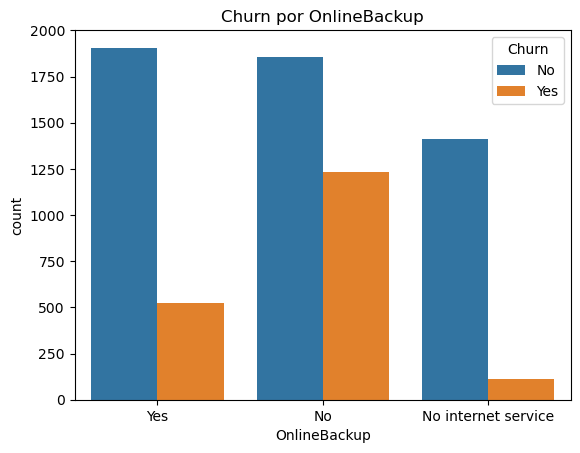

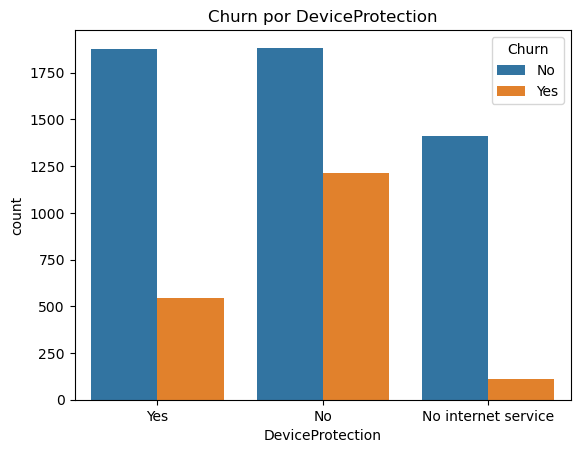

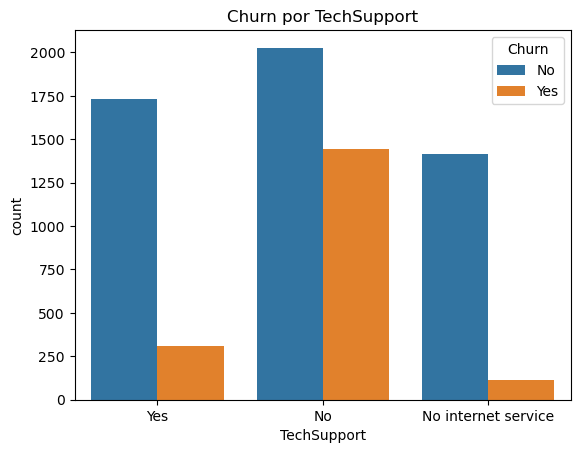

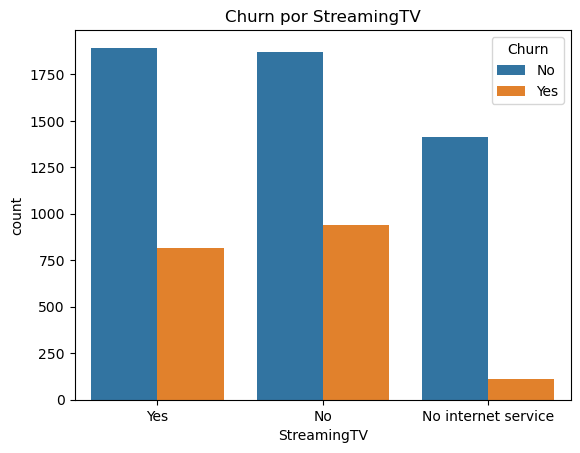

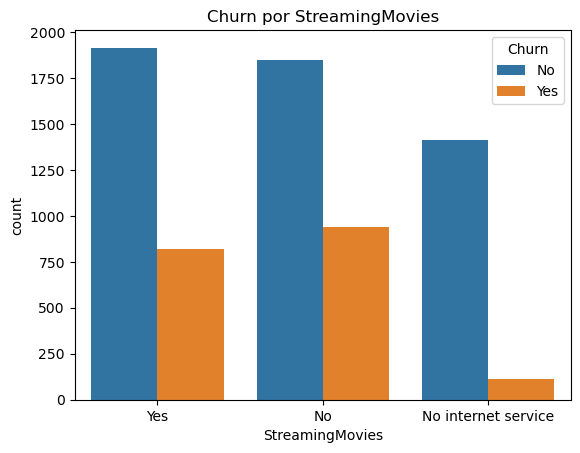

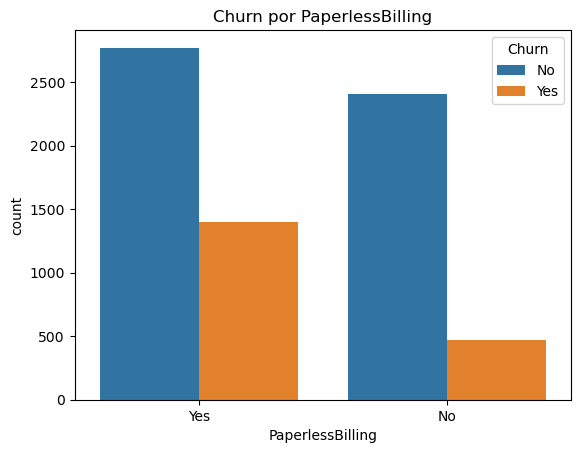

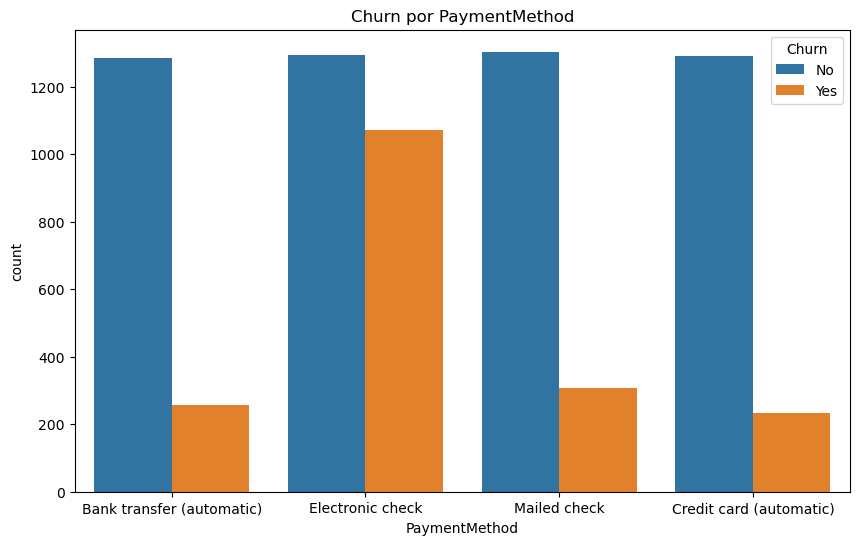

In [36]:


# Gráfico de barras para variáveis categóricas
sns.countplot(x='gender', hue='Churn', data=df)
plt.title('Churn por Gênero')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Churn por SeniorCitizen')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='Partner', hue='Churn', data=df)
plt.title('Churn por Partner')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='Dependents', hue='Churn', data=df)
plt.title('Churn por Dependents')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='PhoneService', hue='Churn', data=df)
plt.title('Churn por PhoneService')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='MultipleLines', hue='Churn', data=df)
plt.title('Churn por MultipleLines')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn por InternetService')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='OnlineSecurity', hue='Churn', data=df)
plt.title('Churn por OnlineSecurity')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='OnlineBackup', hue='Churn', data=df)
plt.title('Churn por OnlineBackup')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='DeviceProtection', hue='Churn', data=df)
plt.title('Churn por DeviceProtection')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='TechSupport', hue='Churn', data=df)
plt.title('Churn por TechSupport')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='StreamingTV', hue='Churn', data=df)
plt.title('Churn por StreamingTV')
plt.show()
# Gráfico de barras para variáveis categóricas
sns.countplot(x='StreamingMovies', hue='Churn', data=df)
plt.title('Churn por StreamingMovies')
plt.show()

# Gráfico de barras para variáveis categóricas
sns.countplot(x='PaperlessBilling', hue='Churn', data=df)
plt.title('Churn por PaperlessBilling')
plt.show()
# Gráfico de barras para variáveis categóricas
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Churn por PaymentMethod')
plt.show()



									

In [37]:
# desses gráficos podemos tirar algumas informações interessantes para identificação de grupos de interesse

### 2 - Correlações Pearson

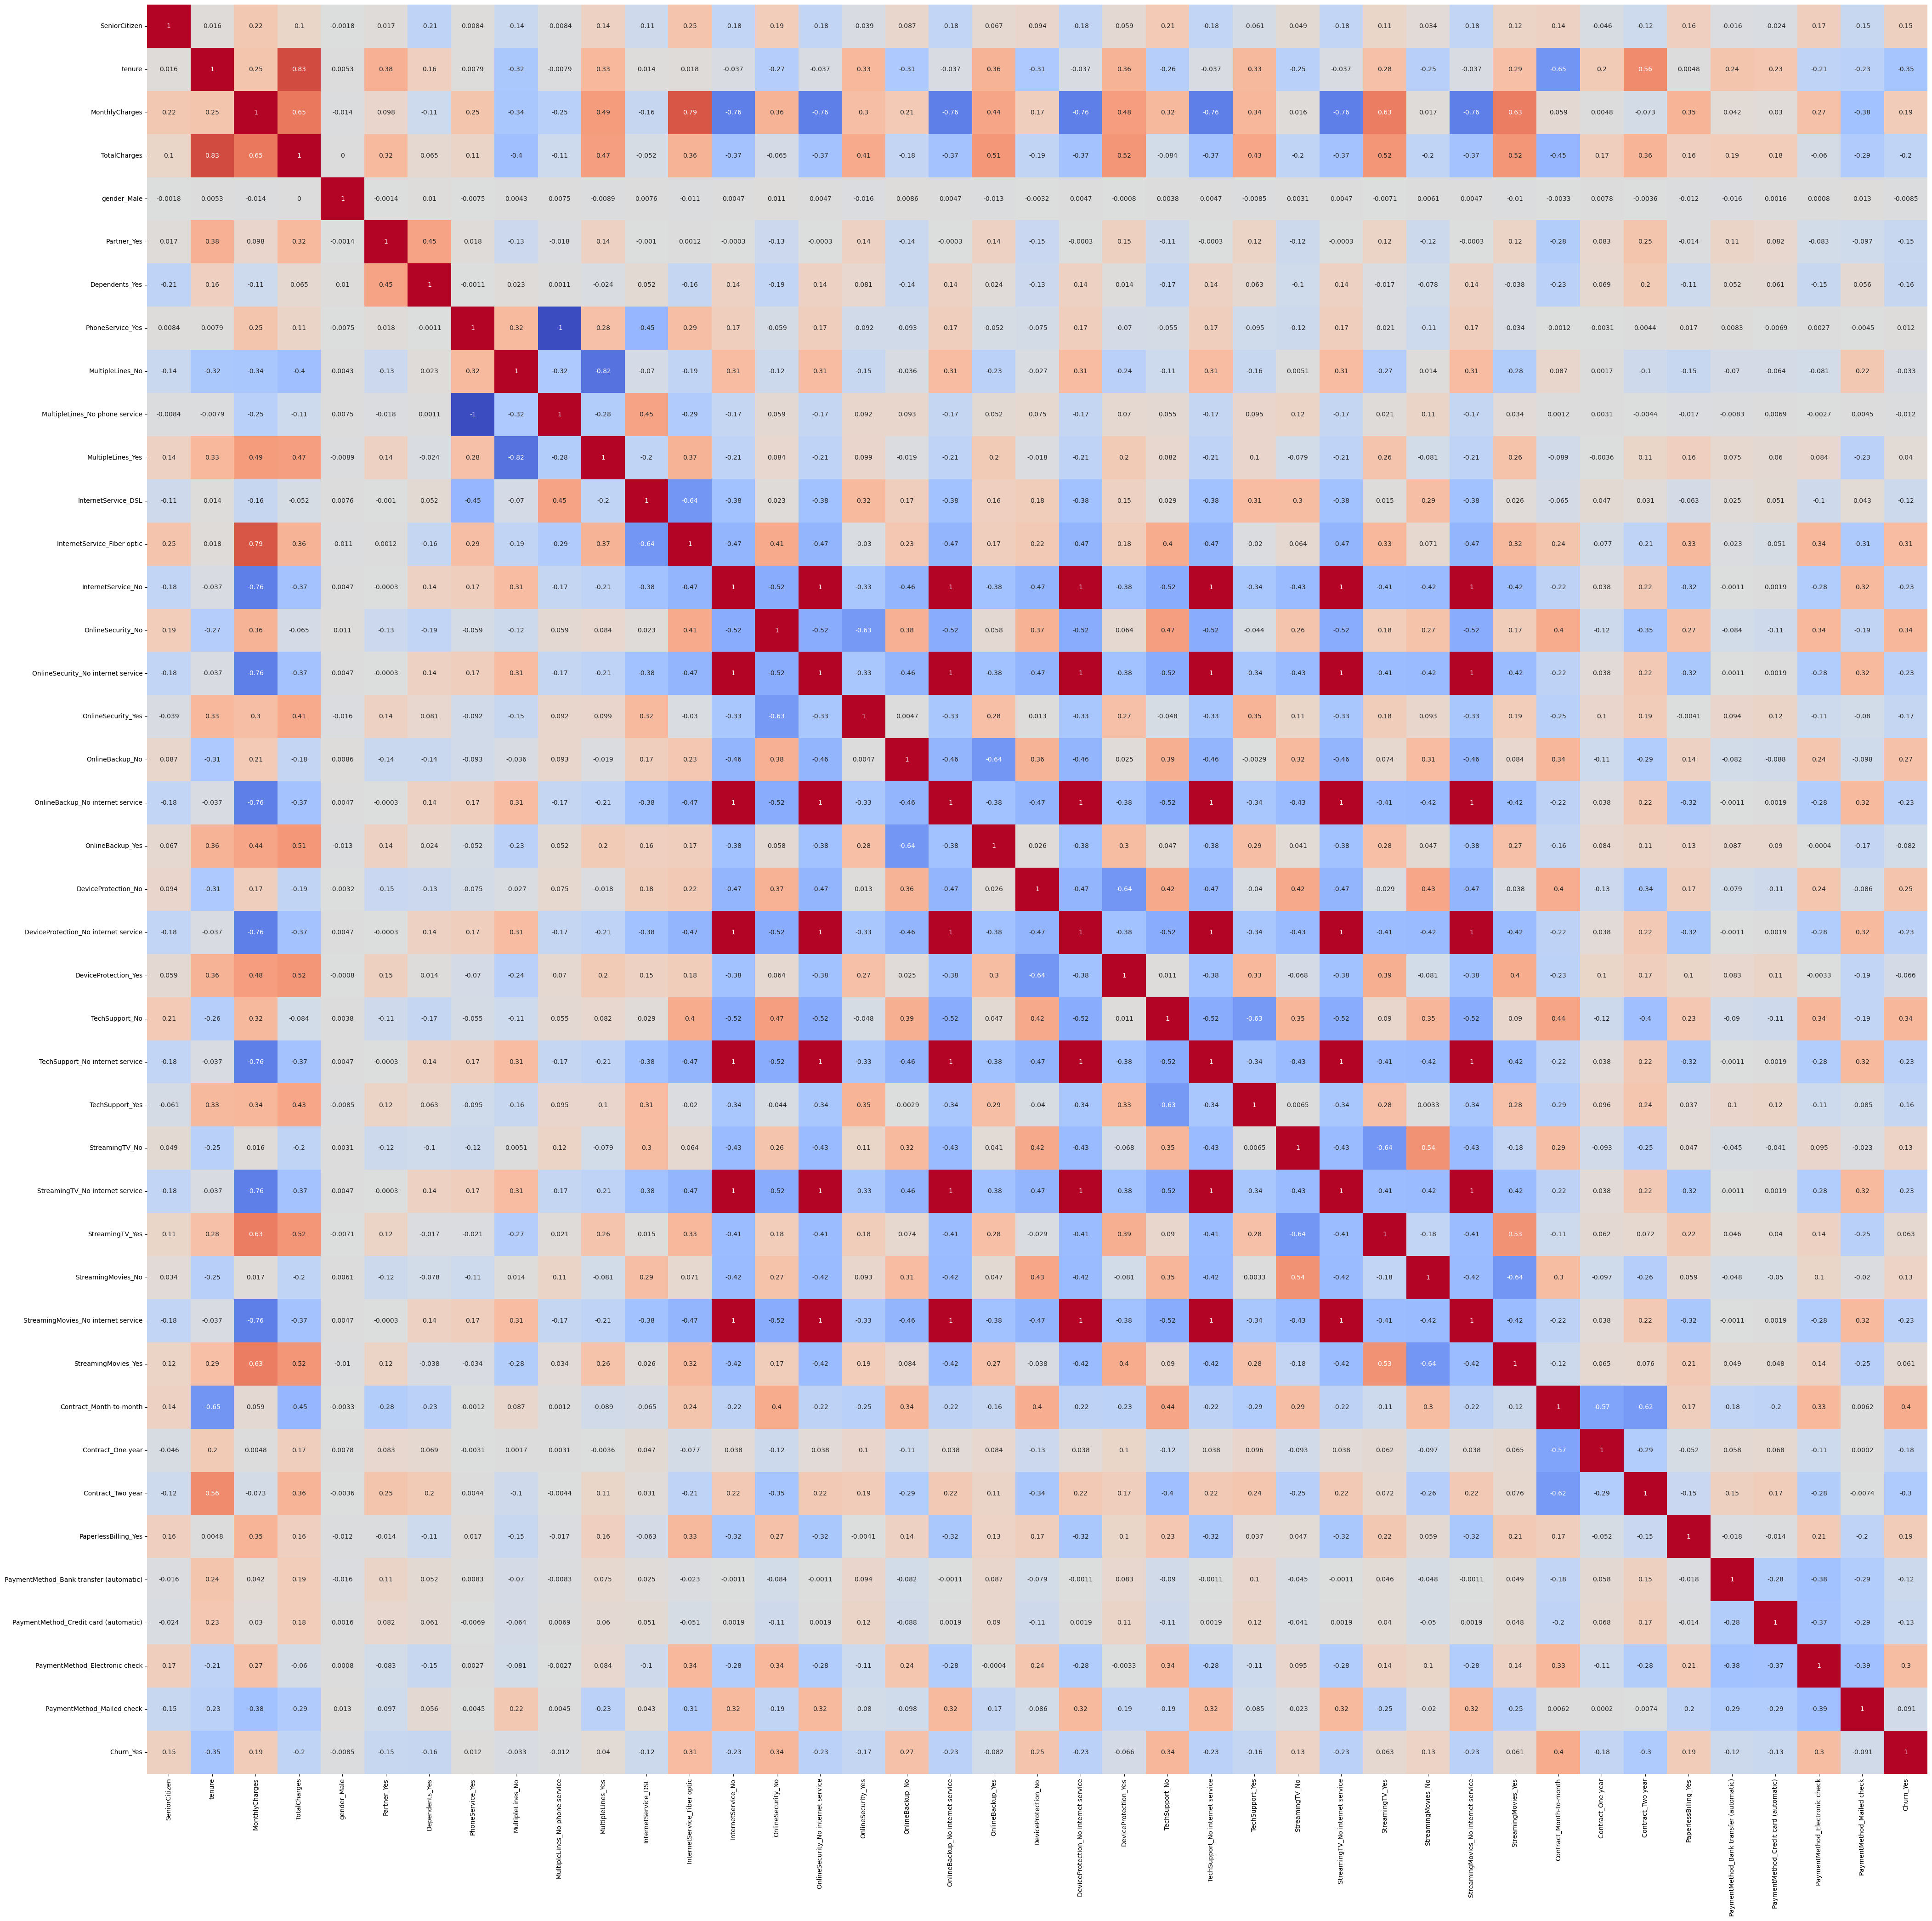

In [38]:

# Matriz de correlação
corr_matrix = df_encoded.drop('customerID', axis=1).corr()
plt.figure(figsize=(50, 50))
sns.heatmap(round(corr_matrix, 4), annot=True, cmap='coolwarm', cbar=False)
# plt.title('Matriz de Correlação')
plt.show()

In [39]:
corr_matrix['Churn_Yes'].sort_values(ascending=False)

Churn_Yes                                  1.00
Contract_Month-to-month                    0.40
OnlineSecurity_No                          0.34
TechSupport_No                             0.34
InternetService_Fiber optic                0.31
PaymentMethod_Electronic check             0.30
OnlineBackup_No                            0.27
DeviceProtection_No                        0.25
MonthlyCharges                             0.19
PaperlessBilling_Yes                       0.19
SeniorCitizen                              0.15
StreamingMovies_No                         0.13
StreamingTV_No                             0.13
StreamingTV_Yes                            0.06
StreamingMovies_Yes                        0.06
MultipleLines_Yes                          0.04
PhoneService_Yes                           0.01
gender_Male                               -0.01
MultipleLines_No phone service            -0.01
MultipleLines_No                          -0.03
DeviceProtection_Yes                    

In [40]:
# identificando correlações maiores do que 80%

for i in corr_matrix.columns:
    for j in corr_matrix.index:
        if (i!=j) and (corr_matrix[i][j]>0.8):
            print(i, j, ' ', corr_matrix[i][j])


tenure TotalCharges   0.8258804609332026
TotalCharges tenure   0.8258804609332026
InternetService_No OnlineSecurity_No internet service   1.0
InternetService_No OnlineBackup_No internet service   1.0
InternetService_No DeviceProtection_No internet service   1.0
InternetService_No TechSupport_No internet service   1.0
InternetService_No StreamingTV_No internet service   1.0
InternetService_No StreamingMovies_No internet service   1.0
OnlineSecurity_No internet service InternetService_No   1.0
OnlineSecurity_No internet service OnlineBackup_No internet service   1.0
OnlineSecurity_No internet service DeviceProtection_No internet service   1.0
OnlineSecurity_No internet service TechSupport_No internet service   1.0
OnlineSecurity_No internet service StreamingTV_No internet service   1.0
OnlineSecurity_No internet service StreamingMovies_No internet service   1.0
OnlineBackup_No internet service InternetService_No   1.0
OnlineBackup_No internet service OnlineSecurity_No internet service   

<Axes: xlabel='tenure', ylabel='TotalCharges'>

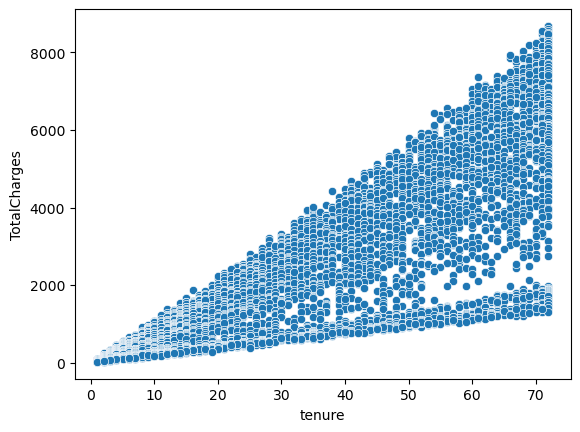

In [41]:
# usualmente costumo remover correlações muito altas para evitar colinearidade
sns.scatterplot(x='tenure', y='TotalCharges', data=df[['tenure','TotalCharges']])

### 3 - Correlações Spearman

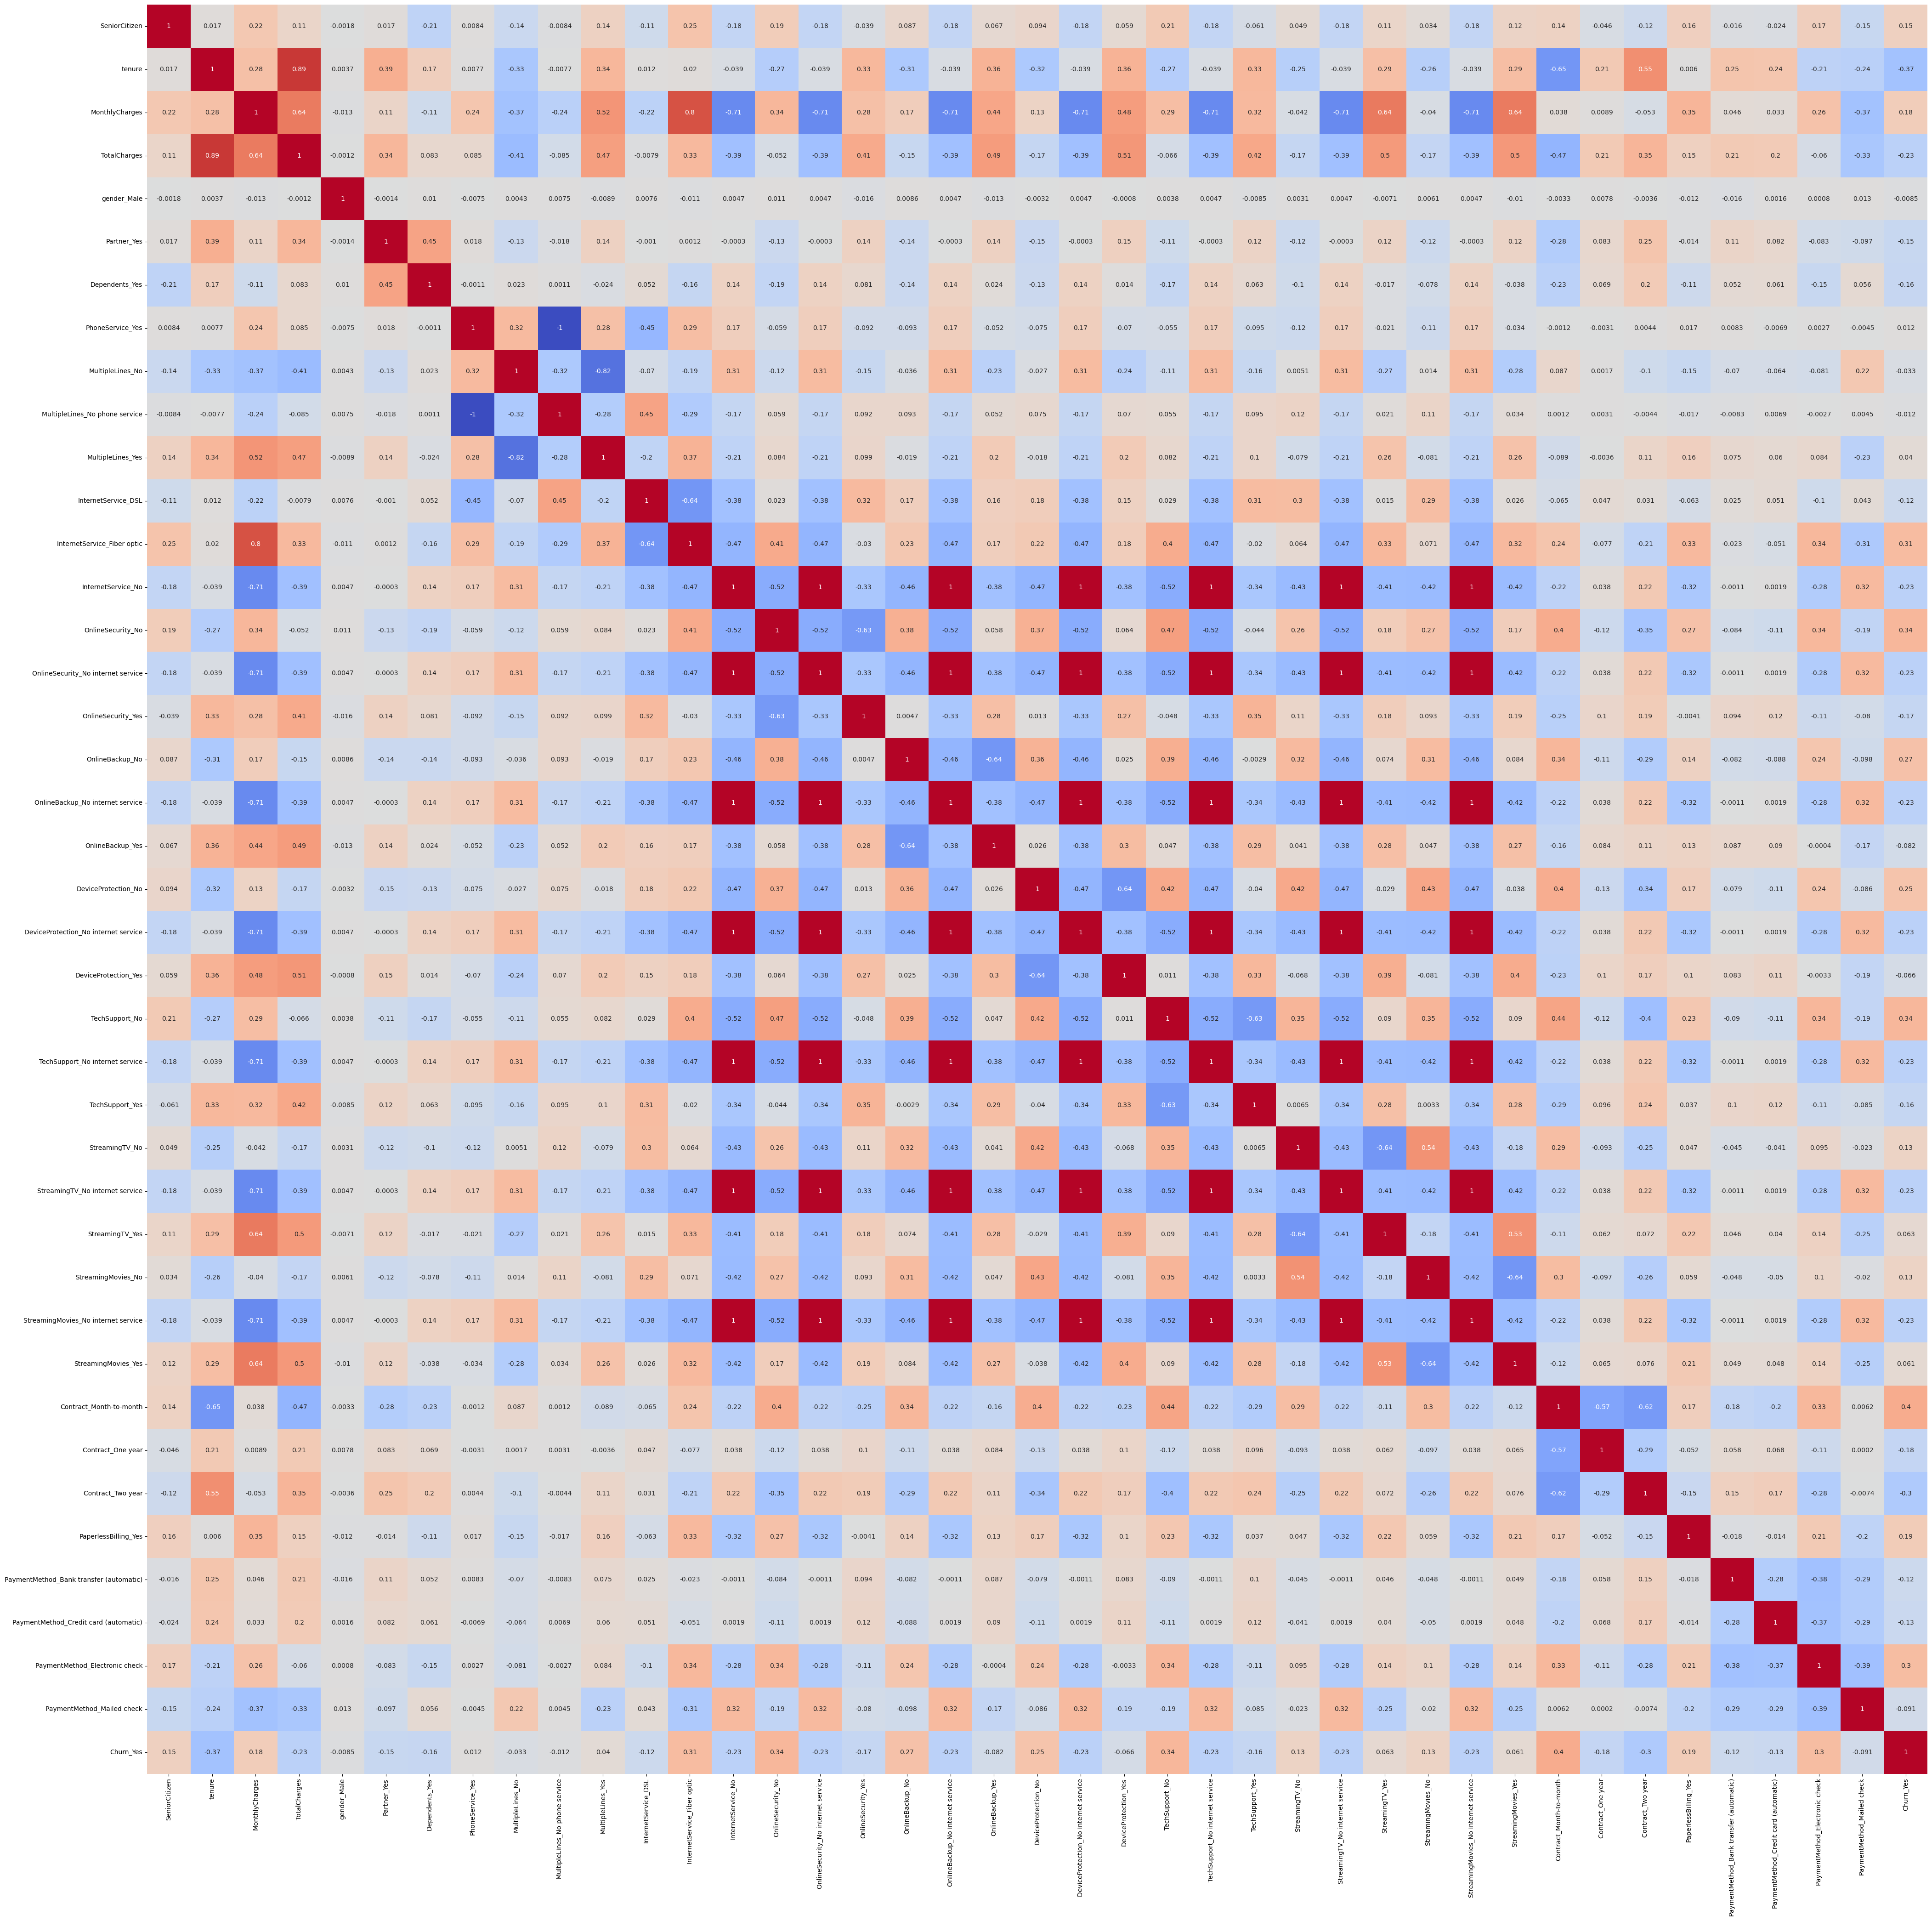

In [42]:
# Matriz de correlação spearman 

corr_matrix = df_encoded.drop('customerID', axis=1).corr('spearman')
plt.figure(figsize=(50, 50))
sns.heatmap(round(corr_matrix, 4), annot=True, cmap='coolwarm', cbar=False)
# plt.title('Matriz de Correlação')
plt.show()

In [43]:
corr_matrix['Churn_Yes'].sort_values(ascending=False)

Churn_Yes                                  1.00
Contract_Month-to-month                    0.40
OnlineSecurity_No                          0.34
TechSupport_No                             0.34
InternetService_Fiber optic                0.31
PaymentMethod_Electronic check             0.30
OnlineBackup_No                            0.27
DeviceProtection_No                        0.25
PaperlessBilling_Yes                       0.19
MonthlyCharges                             0.18
SeniorCitizen                              0.15
StreamingMovies_No                         0.13
StreamingTV_No                             0.13
StreamingTV_Yes                            0.06
StreamingMovies_Yes                        0.06
MultipleLines_Yes                          0.04
PhoneService_Yes                           0.01
gender_Male                               -0.01
MultipleLines_No phone service            -0.01
MultipleLines_No                          -0.03
DeviceProtection_Yes                    

In [44]:
for i in corr_matrix.columns:
    for j in corr_matrix.index:
        if (i!=j) and (corr_matrix[i][j]>0.8):
            print(i, j, ' ', corr_matrix[i][j])


tenure TotalCharges   0.8891770805365491
TotalCharges tenure   0.8891770805365491
InternetService_No OnlineSecurity_No internet service   1.0
InternetService_No OnlineBackup_No internet service   1.0
InternetService_No DeviceProtection_No internet service   1.0
InternetService_No TechSupport_No internet service   1.0
InternetService_No StreamingTV_No internet service   1.0
InternetService_No StreamingMovies_No internet service   1.0
OnlineSecurity_No internet service InternetService_No   1.0
OnlineSecurity_No internet service OnlineBackup_No internet service   1.0
OnlineSecurity_No internet service DeviceProtection_No internet service   1.0
OnlineSecurity_No internet service TechSupport_No internet service   1.0
OnlineSecurity_No internet service StreamingTV_No internet service   1.0
OnlineSecurity_No internet service StreamingMovies_No internet service   1.0
OnlineBackup_No internet service InternetService_No   1.0
OnlineBackup_No internet service OnlineSecurity_No internet service   

# Modelagem

In [45]:
# Inicialmente vou testar alguns modelos usando o LazyClassifier, e escolher alguns modelos para evoluir 

In [46]:
# Removendo colunas com altas correlações para evitar vies no modelo


X_train = X_train.drop(['OnlineSecurity_No internet service',
                                'OnlineBackup_No internet service',
                                'DeviceProtection_No internet service',
                                'TechSupport_No internet service',
                                'StreamingTV_No internet service',
                                'StreamingMovies_No internet service','TotalCharges'], axis=1)

X_test = X_test.drop(['OnlineSecurity_No internet service',
                                'OnlineBackup_No internet service',
                                'DeviceProtection_No internet service',
                                'TechSupport_No internet service',
                                'StreamingTV_No internet service',
                                'StreamingMovies_No internet service','TotalCharges'], axis=1)


columns = X_train.columns


### 1 - Normalizar dados

In [47]:
# Primeiro Vamos normalizar ou padronizar os dados 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)

X_test = scaler.transform(X_test)

X_test = pd.DataFrame(X_test, columns=columns, index=index_test)


### 2 - Seleção de Variáveis

In [48]:
# Esse metodo combinado de seleção de variáveis eu montei a um tempo, normalmente é bem útil para reduzir numero de features
# e acaba tendo uma compatibilidade interessante com feature importance e shap

## Pearson:
def correlacao(X, y, num_feats):
    '''
    Seleciona features por Correlação
    '''
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    return cor_support, cor_feature

## VarianceThreshold
def variancia(X, y, num_feats):
    '''
    Seleciona features por Limite de variância
    '''

    embeded_var_selector = VarianceThreshold(threshold=(.1))
    embeded_var_selector.fit(X)

    embeded_var_support = embeded_var_selector.get_support()
    embeded_var_feature = X.loc[:,embeded_var_support].columns.tolist()
    #print(str(len(embeded_rf_feature)), 'selected features')

    
    return embeded_var_support, embeded_var_feature
## Lasso:
def lasso(X, y, num_feats):
    '''
    Seleciona features por penalização L1 em regressão Logistica
    '''
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
    embeded_lr_selector.fit(X, y)

    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    #print(str(len(embeded_lr_feature)), 'selected features')
    
    return embeded_lr_support, embeded_lr_feature

## Floresta:
def floresta(X, y, num_feats):
    '''
    Seleciona features usando random forest
    '''
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    #print(str(len(embeded_rf_feature)), 'selected features')
    
    return embeded_rf_support, embeded_rf_feature

def ensamble(X, y, num_feats):
    '''
    Seleciona features usando Ensamble LightGBM
    '''
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    return embeded_lgb_support, embeded_lgb_feature

## RFE:
def recursivo(X, y, num_feats, model):
    '''
    Seleciona features usando estimador fornecido
    '''

    cor_list = []
    feature_name = X.columns.tolist()

    rfe_selector = RFE(estimator=model, n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    #print(str(len(rfe_feature)), 'selected features') 

    return rfe_support, rfe_feature



## Permutation importance
def permutacao(X, y, num_feats, model):
    '''
    Seleciona features usando permutação
    '''
    model.fit(X, y)
    r = permutation_importance(model, X, y,
                           n_repeats=5,
                           random_state=42)
    embeded_permutation_support = np.where(r.importances_mean>0, True, False)
    embeded_permutation_feature = X.loc[:,embeded_permutation_support].columns.tolist()
    #print(str(len(embeded_rf_feature)), 'selected features')

    return embeded_permutation_support, embeded_permutation_feature

def feature_selection(X, y, num_feats, model=None):
    '''

    '''
    feature_name = X.columns.tolist()
    X_norm = MinMaxScaler().fit_transform(X)
    X_norm = pd.DataFrame(X_norm, columns=feature_name)
    ## Pearson
    cor_support, cor_feature = correlacao(X, y, num_feats)
    ## VarianceThreshold
    embeded_var_support, embeded_var_feature = variancia(X, y, num_feats)
    ## Lasso
    embeded_lr_support, embeded_lr_feature = lasso(X_norm, y, num_feats)
    ## Floresta
    embeded_rf_support, embeded_rf_feature = floresta(X, y, num_feats)
    ## Ensamble
    embeded_lgb_support, embeded_lgb_feature = ensamble(X, y, num_feats)
    ## RFE
    rfe_support, rfe_feature = recursivo(X_norm, y, num_feats, model)
    ## Permutation
    embeded_permutation_support, embeded_permutation_feature = permutacao(X_norm, y, num_feats, model)


    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':feature_name, 
                                         'Pearson':cor_support, 
                                         'Variancia':embeded_var_support, 
                                         'Lasso':embeded_lr_support,
                                         'Random Forest':embeded_rf_support,
                                         'Ensamble':embeded_lgb_support,
                                         'RFE':rfe_support, 
                                         'Permutação':embeded_permutation_support
                                         })


    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df.iloc[:, 1:].astype(bool), axis=1)

    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    #feature_selection_df.head(num_feats)
    return feature_selection_df

model = XGBClassifier()

# Aplicação da função de seleção de features
df_features = feature_selection(X=X_train, y=y_train, num_feats=15, model=model)

Fitting estimator with 33 features.
Fitting estimator with 23 features.


In [49]:
df_features

Feature  Pearson  Variancia  Lasso   
1                                    tenure     True       True   True  \
2                      PaperlessBilling_Yes     True       True   True   
3               InternetService_Fiber optic     True       True   True   
4                   Contract_Month-to-month     True       True   True   
5                            TechSupport_No     True       True  False   
6                          MultipleLines_No    False       True   True   
7                            MonthlyCharges     True       True  False   
8                         Contract_Two year     True       True   True   
9                         Contract_One year     True       True   True   
10                         PhoneService_Yes    False       True   True   
11           PaymentMethod_Electronic check     True       True   True   
12                       OnlineSecurity_Yes     True       True   True   
13                        OnlineSecurity_No     True       True  False   
14                       InternetService_No     True       True   True   
15                      InternetService_DSL    False       True   True   
16                           Dependents_Yes     True       True   True   
17                              gender_Male    False       True  False   
18                          TechSupport_Yes    False       True   True   
19                          StreamingTV_Yes    False       True   True   
20                           StreamingTV_No    False       True  False   
21                       StreamingMovies_No    False       True  False   
22                            SeniorCitizen    False       True  False   
23               PaymentMethod_Mailed check    False       True  False   
24                              Partner_Yes    False       True  False   
25                          OnlineBackup_No     True       True  False   
26                      DeviceProtection_No     True       True  False   
27                      StreamingMovies_Yes    False       True  False   
28    PaymentMethod_Credit card (automatic)    False       True  False   
29  PaymentMethod_Bank transfer (automatic)    False       True  False   
30                         OnlineBackup_Yes    False       True  False   
31                        MultipleLines_Yes    False       True  False   
32                     DeviceProtection_Yes    False       True  False   
33           MultipleLines_No phone service    False       True  False   

    Random Forest  Ensamble    RFE  Permutação  Total  
1            True      True   True        True      7  
2           False      True   True        True      6  
3           False      True   True        True      6  
4            True     False   True        True      6  
5            True     False   True        True      5  
6           False      True   True        True      5  
7            True      True  False        True      5  
8           False     False   True        True      5  
9           False     False   True        True      5  
10          False     False   True        True      4  
11          False     False  False        True      4  
12          False     False  False        True      4  
13          False     False   True        True      4  
14          False     False  False        True      4  
15          False     False   True        True      4  
16          False     False  False        True      4  
17           True     False  False        True      3  
18          False     False  False        True      3  
19          False     False  False        True      3  
20          False     False   True        True      3  
21          False     False   True        True      3  
22          False     False   True        True      3  
23          False     False   True        True      3  
24          False      True  False        True      3  
25          False     False  False        True      3  
26          False     False  False        True      3  
27     

In [50]:
# pegando as features que são relevantes em ao menos 4 metodos

selected_features_df = df_features[df_features.Total > 3]
selected_features = selected_features_df.Feature.values

In [51]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [52]:
X_train.shape

(4711, 16)

### 3 - Comparação de Multiplos Modelos

In [53]:
lz = LazyClassifier(predictions=True)
lz_df, predictions = lz.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:05<00:00,  5.38it/s]


In [54]:
lz_df.sort_values(by='F1 Score', ascending=False)

Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
LogisticRegression                 0.81               0.73     0.73      0.80  \
LinearSVC                          0.81               0.73     0.73      0.80   
CalibratedClassifierCV             0.81               0.73     0.73      0.80   
LinearDiscriminantAnalysis         0.80               0.73     0.73      0.80   
RidgeClassifierCV                  0.81               0.72     0.72      0.80   
RidgeClassifier                    0.81               0.72     0.72      0.80   
SVC                                0.81               0.72     0.72      0.80   
AdaBoostClassifier                 0.80               0.72     0.72      0.79   
SGDClassifier                      0.79               0.71     0.71      0.79   
KNeighborsClassifier               0.79               0.72     0.72      0.79   
XGBClassifier                      0.79               0.72     0.72      0.79   
LGBMClassifier                     0.79               0.71     0.71      0.79   
NuSVC                              0.79               0.67     0.67      0.78   
LabelSpreading                     0.77               0.71     0.71      0.77   
Perceptron                         0.79               0.67     0.67      0.77   
RandomForestClassifier             0.78               0.69     0.69      0.77   
BernoulliNB                        0.76               0.75     0.75      0.77   
LabelPropagation                   0.77               0.71     0.71      0.77   
QuadraticDiscriminantAnalysis      0.75               0.74     0.74      0.76   
BaggingClassifier                  0.77               0.67     0.67      0.76   
ExtraTreesClassifier               0.76               0.68     0.68      0.76   
ExtraTreeClassifier                0.75               0.68     0.68      0.75   
NearestCentroid                    0.73               0.75     0.75      0.74   
GaussianNB                         0.72               0.74     0.74      0.74   
DecisionTreeClassifier             0.74               0.66     0.66      0.74   
PassiveAggressiveClassifier        0.68               0.68     0.68      0.69   
DummyClassifier                    0.73               0.50     0.50      0.62   

                               Time Taken  
Model                                      
LogisticRegression                   0.02  
LinearSVC                            0.13  
CalibratedClassifierCV               0.06  
LinearDiscriminantAnalysis           0.03  
RidgeClassifierCV                    0.02  
RidgeClassifier                      0.01  
SVC                                  0.62  
AdaBoostClassifier                   0.16  
SGDClassifier                        0.03  
KNeighborsClassifier                 0.32  
XGBClassifier                        0.16  
LGBMClassifier                       0.10  
NuSVC                                0.69  
LabelSpreading                       1.17  
Perceptron                           0.02  
RandomForestClassifier               0.34  
BernoulliNB                          0.01  
LabelPropagation                     0.93  
QuadraticDiscriminantAnalysis        0.03  
BaggingClassifier                    0.09  
ExtraTreesClassifier                 0.32  
ExtraTreeClassifier                  0.02  
NearestCentroid                      0.01  
GaussianNB                           0.01  
DecisionTreeClassifier               0.02  
PassiveAggressiveClassifier          0.02  
DummyClassifier                      0.01

In [55]:
# da tabela vou separar  LogisticRegression, XGBClassifier e DummyClassifier

#### 3.1 - DummyClassifier

In [56]:
# Primeiro podemos fazer um DummyClassifier estratificado para ter uma referência mínima, os resultados do LazyPredict usam 'prior'
# como estratégia de classificação

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.6122361051271004

In [57]:

def generate_classification_metrics(y_true, y_pred):
    '''
    Função para gerar as métricas dos modelos
    '''
    # Calculando métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Criando um DataFrame para a tabela
    metrics_df = pd.DataFrame({
        'Métrica': ['Acurácia', 'Precisão', 'Revocação', 'F1-Score'],
        'Valor': [accuracy, precision, recall, f1]
    })
    
    # Criando DataFrame para a matriz de confusão
    cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
    
    return metrics_df, cm_df


metrics, cm = generate_classification_metrics(y_test, y_pred)

In [58]:
metrics

Métrica  Valor
0   Acurácia   0.61
1   Precisão   0.27
2  Revocação   0.27
3   F1-Score   0.27

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      1704
         1.0       0.27      0.27      0.27       617

    accuracy                           0.61      2321
   macro avg       0.50      0.50      0.50      2321
weighted avg       0.61      0.61      0.61      2321



Text(33.222222222222214, 0.5, 'Valor verdadeiro')

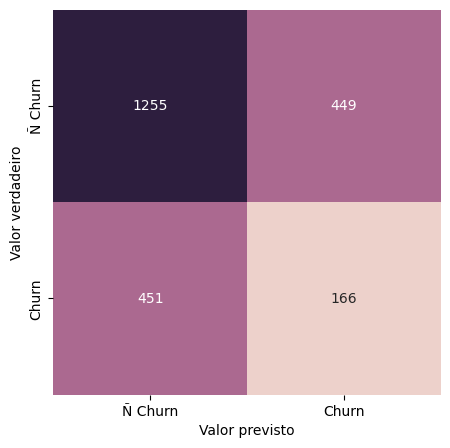

In [60]:
labels = ['Ñ Churn', 'Churn']
plt.figure(figsize=(5, 5))
# Cria o heatmap usando o seaborn
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g', xticklabels=labels, yticklabels=labels, cbar=False, norm=matplotlib.colors.LogNorm())
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')

#### 3.2 - Regressão Logistica

In [61]:
# Regressão Logistica, na tabela foi um dos modelos que apresentou melhor resultado.

logr = LogisticRegression()
logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)
logr.score(X_test, y_test)

0.8082722964239551

<Axes: >

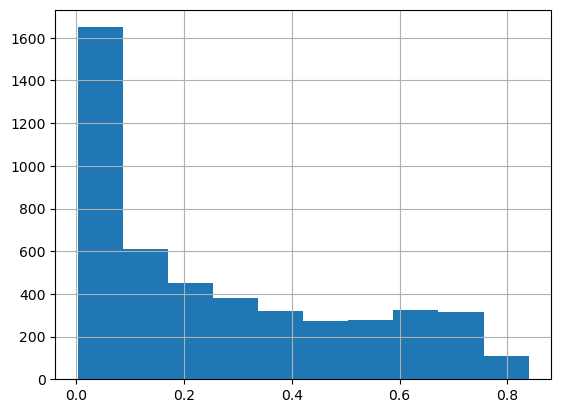

In [62]:
y_pred_train_proba = logr.predict_proba(X_train)
pd.DataFrame(y_pred_train_proba)[1].hist()

In [63]:
metrics, cm = generate_classification_metrics(y_test, y_pred)

In [64]:
metrics

Métrica  Valor
0   Acurácia   0.81
1   Precisão   0.66
2  Revocação   0.56
3   F1-Score   0.61

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1704
         1.0       0.66      0.56      0.61       617

    accuracy                           0.81      2321
   macro avg       0.76      0.73      0.74      2321
weighted avg       0.80      0.81      0.80      2321



Text(33.222222222222214, 0.5, 'Valor verdadeiro')

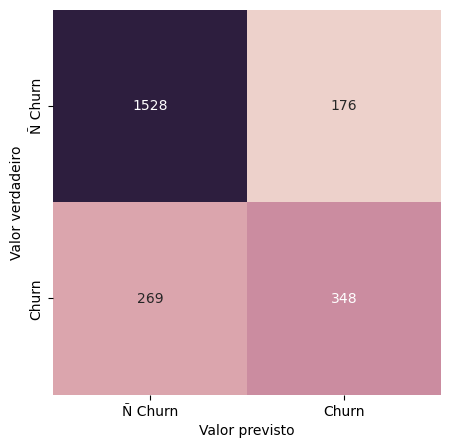

In [66]:
labels = ['Ñ Churn', 'Churn']
plt.figure(figsize=(5, 5))
# Cria o heatmap usando o seaborn
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g', xticklabels=labels, yticklabels=labels, cbar=False, norm=matplotlib.colors.LogNorm())
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')

#### 3.4 - XgBoost

In [67]:
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
xgbc.score(X_test, y_test)

0.7927617406290393

<Axes: >

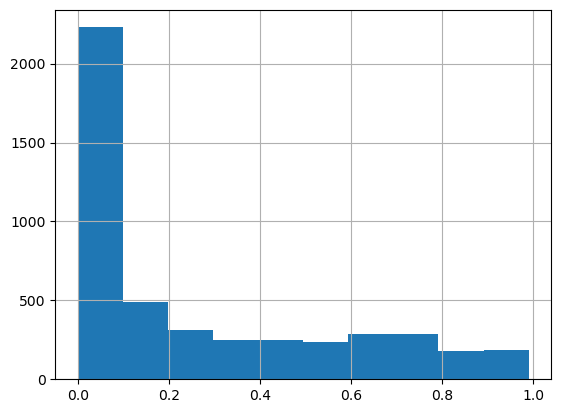

In [68]:
y_pred_train_proba = xgbc.predict_proba(X_train)
pd.DataFrame(y_pred_train_proba)[1].hist()

In [69]:
metrics, cm = generate_classification_metrics(y_test, y_pred)

In [70]:
metrics

Métrica  Valor
0   Acurácia   0.79
1   Precisão   0.63
2  Revocação   0.55
3   F1-Score   0.58

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      1704
         1.0       0.63      0.55      0.58       617

    accuracy                           0.79      2321
   macro avg       0.73      0.72      0.72      2321
weighted avg       0.79      0.79      0.79      2321



Text(33.222222222222214, 0.5, 'Valor verdadeiro')

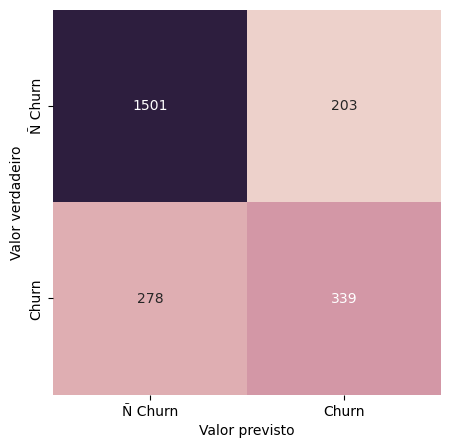

In [72]:
labels = ['Ñ Churn', 'Churn']
plt.figure(figsize=(5, 5))
# Cria o heatmap usando o seaborn
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g', xticklabels=labels, yticklabels=labels, cbar=False, norm=matplotlib.colors.LogNorm())
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')

In [73]:
# O modelo que melhor performou, sem alterações de hyperparametros foi uma regresão logistica
# porém a diferença entre os modelos é muito baixa
# para verificação vou usar o xgboost e buscar otimizar seus hyperparametros junto a regressão logistica


##### 3.4.1 - Otimização de Hyperparametros

In [74]:
# Usando optuna
def train_xgb(X_train, y_train, X_test, y_test, **params):
    '''
    função de treino do XGB para o Optuna
    '''
    xgb = XGBClassifier(
        random_state=42, 
        **params
    )
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    return f1_score(y_test, y_pred)

def objective_xgb(trial):
    '''
    Função de objetivo para o estudo do optuna XGB
    '''
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0)
    }

    score = train_xgb(X_train, y_train, X_test, y_test, **params)

    return score

def train_logireg(X_train, y_train, X_test, y_test, **params):
    '''
    Treino da regressão logistica
    '''
    logr = LogisticRegression(
        random_state=42, 
        **params
    )
    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_test)
    return f1_score(y_test, y_pred)

def objective_logireg(trial):
    '''
    Função objetivo para o modelo de regressão logistica
    '''
    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1),
        "n_jobs" : -1
    }

    score = train_logireg(X_train, y_train, X_test, y_test, **params)

    return score

In [75]:
models_dict = {'XGBClassifier': [XGBClassifier, objective_xgb],
               'LogiReg': [LogisticRegression, objective_logireg]
              }

In [76]:
# Rodar optuna

model_selection_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'])
model_selection_dict = {}

for model in list(set(['XGBClassifier', 'LogiReg'])):
    sampler = optuna.samplers.TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(models_dict[model][1], n_trials = 150)
    trial = study.best_trial
    try:
        model_temp = models_dict[model][0](random_state=42, **trial.params)
        params = trial.params
        params['random_state'] = 42
    except:
        model_temp = models_dict[model][0](**trial.params)
        params = trial.params
    model_selection_dict[model] = params

[I 2024-04-27 21:54:33,911] A new study created in memory with name: no-name-799a3860-72f1-4d97-bf4e-c90108fa9455
[I 2024-04-27 21:54:35,102] Trial 0 finished with value: 0.6099912357581069 and parameters: {'tol': 0.0003751655787285152, 'C': 0.7969454818643931}. Best is trial 0 with value: 0.6099912357581069.
[I 2024-04-27 21:54:35,589] Trial 1 finished with value: 0.6103781882145998 and parameters: {'tol': 0.0007322619478695938, 'C': 0.15751320499779725}. Best is trial 1 with value: 0.6103781882145998.
[I 2024-04-27 21:54:36,092] Trial 2 finished with value: 0.605683836589698 and parameters: {'tol': 0.0001568626218019941, 'C': 0.020511104188433976}. Best is trial 1 with value: 0.6103781882145998.
[I 2024-04-27 21:54:36,558] Trial 3 finished with value: 0.6099912357581069 and parameters: {'tol': 5.9025528556031264e-05, 'C': 0.5399484409787431}. Best is trial 1 with value: 0.6103781882145998.
[I 2024-04-27 21:54:37,022] Trial 4 finished with value: 0.6098418277680141 and parameters: {'t

In [77]:
# novos hyperparametros

model_selection_dict

{'LogiReg': {'tol': 0.0009376235982066566,
  'C': 0.18847827615716134,
  'random_state': 42},
 'XGBClassifier': {'n_estimators': 672,
  'max_depth': 3,
  'learning_rate': 0.007126207551570017,
  'gamma': 0.09495599035272456,
  'min_child_weight': 5,
  'subsample': 0.9408437759207542,
  'colsample_bytree': 0.7945975764816423,
  'reg_alpha': 2.761937719343766e-05,
  'reg_lambda': 0.7982390018926524,
  'scale_pos_weight': 1.770319483624914,
  'random_state': 42}}

In [78]:
# novo modelo logistico com hyperparametros

model = LogisticRegression(**model_selection_dict['LogiReg'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.8095648427401982

In [79]:
metrics, cm = generate_classification_metrics(y_test, y_pred)

In [80]:
metrics

Métrica  Valor
0   Acurácia   0.81
1   Precisão   0.67
2  Revocação   0.56
3   F1-Score   0.61

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1704
         1.0       0.67      0.56      0.61       617

    accuracy                           0.81      2321
   macro avg       0.76      0.73      0.74      2321
weighted avg       0.80      0.81      0.80      2321



Text(33.222222222222214, 0.5, 'Valor verdadeiro')

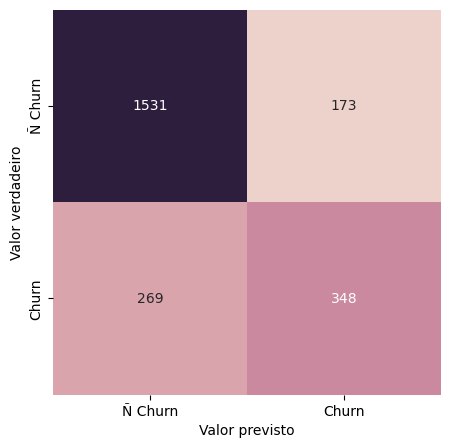

In [82]:
labels = ['Ñ Churn', 'Churn']
plt.figure(figsize=(5, 5))
# Cria o heatmap usando o seaborn
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g', xticklabels=labels, yticklabels=labels, cbar=False, norm=matplotlib.colors.LogNorm())
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')

In [83]:
# novo modelo XGB com hyperparametros
model = XGBClassifier(**model_selection_dict['XGBClassifier'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7992244722102542

In [84]:
metrics, cm = generate_classification_metrics(y_test, y_pred)

In [85]:
metrics

Métrica  Valor
0   Acurácia   0.80
1   Precisão   0.60
2  Revocação   0.71
3   F1-Score   0.65

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86      1704
         1.0       0.60      0.71      0.65       617

    accuracy                           0.80      2321
   macro avg       0.75      0.77      0.76      2321
weighted avg       0.81      0.80      0.80      2321



Text(33.222222222222214, 0.5, 'Valor verdadeiro')

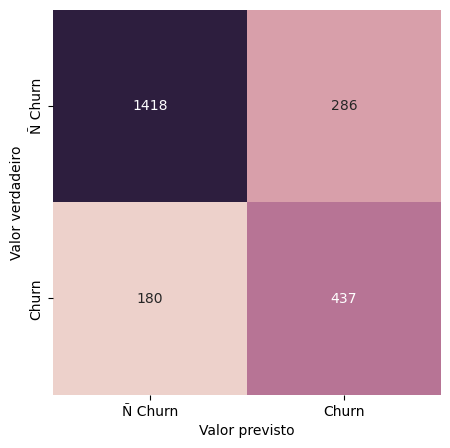

In [87]:
labels = ['Ñ Churn', 'Churn']
plt.figure(figsize=(5, 5))
# Cria o heatmap usando o seaborn
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g', xticklabels=labels, yticklabels=labels, cbar=False, norm=matplotlib.colors.LogNorm())
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')

In [88]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7945975764816423, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.09495599035272456, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.007126207551570017, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=672, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=2.761937719343766e-05,
              reg_lambda=0.7982390018926524, ...)

In [89]:
# O XGB apresentou maior recall o que é mais interessante para o problema de churn
# para maior explicabilidade, porém como pretendo usar shap irei continuar com o Xgboost

##### 3.4.2 - Validação Cruzada

In [90]:
# essa é uma função que desenvolvi a algum tempo para fazer validação cruzada e mais algumas coisinhas

def treino2(X_train, y_train, X_test, y_test, RESPOSTA='status_turnover', model=XGBClassifier(), k_fold=True, k=5,  importance=True, save=True, caminho_imagem='', caminho_importance='', caminho_resultados=''):
    '''
    Função custumizada de treinamento, e criação de métricas iniciais
    
    Input:
           X -> Dados de X (treino e teste),
           y -> Dados de y (treino e teste),
           RESPOSTA -> nome da variável resposta,
           model -> qual o modelo,
           k_fold -> se vai fazer kfold ou não,
           k -> número de folds,
           importance -> deseja gerar feature importance,
           caminho_importance -> caminho para salvar feature importance,
           caminho_resultados -> caminho para salvar resultados,
           caminho_imagem -> caminho para salvar gráficos
    '''
    # X = df.drop(RESPOSTA, axis=1)
    # y = df[RESPOSTA]
    
    if k_fold:
        feature_names = [i for i in (X_train.columns)]
        
        results = pd.DataFrame()

        skf = StratifiedKFold(n_splits=k)#,  random_state=42, n_repeats=3)
        skf.get_n_splits(X_train, y_train)
        
        #f, axes = plt.subplots()

        y_real = []
        y_proba = []

        classifier = model
        #classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

        tprs = []
        aucs = []
        imp = []
        feat = []
        mean_fpr = np.linspace(0, 1, 100)

        fig, ax = plt.subplots(2, 1)
        fig.set_figheight(7)
        fig.set_figwidth(8)

        for i, (train, _) in enumerate(skf.split(X_train, y_train)):

            classifier.fit(X_train.iloc[train], y_train.iloc[train])

            pred = classifier.predict(X_test)
            pred_proba = classifier.predict_proba(X_test)
            precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1])

            lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
            ax[1].step(recall, precision, label=lab)

            y_real.append(y_test)
            y_proba.append(pred_proba[:,1])

            results.loc['accuracy', f'Fold {i+1}'] = accuracy_score(y_test, pred)
            results.loc['precision', f'Fold {i+1}'] = precision_score(y_test, pred)
            results.loc['recall', f'Fold {i+1}'] = recall_score(y_test, pred)
            results.loc['f1_score', f'Fold {i+1}'] = f1_score(y_test, pred)

            if importance:
                importances_index_desc = (classifier[-1].feature_importances_)
                features_order = np.argsort(classifier[-1].feature_importances_)[::1]
                feature_labels = [feature_names[-i] for i in features_order]
                imp.append(importances_index_desc)
                feat.append(feature_labels)

            viz = RocCurveDisplay.from_estimator(
                classifier,
                X_test,
                y_test,
                name=f'ROC fold {i+1}',
                alpha=0.3,
                lw=1,
                ax=ax[0],
            )
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax[0].plot([0, 1], [0, 1], linestyle="--", lw=2, color="#329F8C", label="Acaso", alpha=0.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax[0].plot(
            mean_fpr,
            mean_tpr,
            color="#5A3C58",
            label=r"ROC Média (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        ax[0].fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 desvio padrão",
        )

        ax[0].set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Característica de Operação do Receptor (ROC)",
            
        )

        ax[0].set_xlabel('Taxa de Falsos Positivos (Label Positivo: 1.0)')
        ax[0].set_ylabel('Taxa de Verdadeiros Positivos (Label Positivo: 1.0)')

        box = ax[0].get_position()
        ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #ax[0].legend(loc="lower right")

        y_real = np.concatenate(y_real)
        y_proba = np.concatenate(y_proba)
        precision, recall, _ = precision_recall_curve(y_real, y_proba)
        lab = 'AUC Geral=%.4f' % (auc(recall, precision))
        ax[1].step(recall, precision, label=lab, lw=2, color='black')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precisão')
        ax[1].set(
            #xlim=[-0.05, 1.05],
            #ylim=[-0.05, 1.05],
            title="Curva de Precisão-Recall",
        )
        box = ax[1].get_position()
        ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        
        fig.tight_layout()
        if save:
            plt.savefig(caminho_imagem, dpi =300, transparent = True, bbox_inches='tight')
        plt.show()

        for i in range(len(imp)):
            if i == 0:
                df_importance = pd.DataFrame(imp[i], index=feat[i])
            else:
                a_temp = pd.DataFrame(imp[i], index=feat[i])

                df_importance = df_importance.merge(a_temp, right_index=True, left_index=True, suffixes=('_x', '_y'))
        
        results['media'] = results.mean(axis=1)
        results['Desvio'] = results.drop('media', axis=1).std(axis=1)
        if save:
            round(results, 3).reset_index().rename(columns={'index': 'Métrica', 'media': 'Média'}).replace('accuracy', 'Acurácia').replace('precision', 'Precisão').replace('recall', 'Recall').replace('f1_score', 'F1_score').to_excel(caminho_resultados, index=False)


        return results, classifier
   
    
    else:
        feature_names = [i for i in (X_train.columns)]

        results = pd.DataFrame()

        classifier = model

        tprs = []
        aucs = []
        imp = []
        feat = []
        mean_fpr = np.linspace(0, 1, 100)

        fig, ax = plt.subplots(2, 1)
        fig.set_figheight(7)
        fig.set_figwidth(8)
        classifier.fit(X_train, y_train)

        pred = classifier.predict(X_test)
        pred_proba = classifier.predict_proba(X_test)

        results.loc['accuracy', 'media'] = accuracy_score(y_test, pred)
        results.loc['precision', 'media'] = precision_score(y_test, pred)
        results.loc['recall', 'media'] = recall_score(y_test, pred)
        results.loc['f1_score', 'media'] = f1_score(y_test, pred)

        if importance:
            importances_index_desc = classifier[-1].feature_importances_
            features_order = np.argsort(classifier[-1].feature_importances_)[::1]
            feature_labels = [feature_names[-i] for i in features_order]
            imp.append(importances_index_desc)
            feat.append(feature_labels)

        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name='ROC',
            alpha=0.8,
            color = '#5A3C58',
            lw=2,
            ax=ax[0],
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        ax[0].plot([0, 1], [0, 1], linestyle="--", lw=2, color="#329F8C", label="Acaso", alpha=0.8)

        ax[0].set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Característica de Operação do Receptor (ROC)",
        )

        ax[0].set_xlabel('Taxa de Falsos Positivos (Label Positivo: 1.0)')
        ax[0].set_ylabel('Taxa de Verdadeiros Positivos (Label Positivo: 1.0)')

        box = ax[0].get_position()
        ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #ax[0].legend(loc="lower right")

        precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1])
        lab = 'AUC=%.4f' % (auc(recall, precision))
        ax[1].step(recall, precision, label=lab, lw=2, color='black')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precisão')
        ax[1].set(
            #xlim=[-0.05, 1.05],
            #ylim=[-0.05, 1.05],
            title="Curva de Precisão-Recall",
        )
        box = ax[1].get_position()
        ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        
        fig.tight_layout()
        if save:
            plt.savefig(caminho_imagem, dpi =300, transparent = True, bbox_inches='tight')
        plt.show()

        #f.savefig('result.png')

        for i in range(len(imp)):
            if i == 0:
                df_importance = pd.DataFrame(imp[i], index=feat[i])
            else:
                a_temp = pd.DataFrame(imp[i], index=feat[i])

                df_importance = df_importance.merge(a_temp, right_index=True, left_index=True, suffixes=('_x', '_y'))
        if save:
            round(results, 3).reset_index().rename(columns={'index': 'metrica'}).to_excel(caminho_resultados)

     
        return results, classifier

In [91]:
model = XGBClassifier(**model_selection_dict['XGBClassifier'])

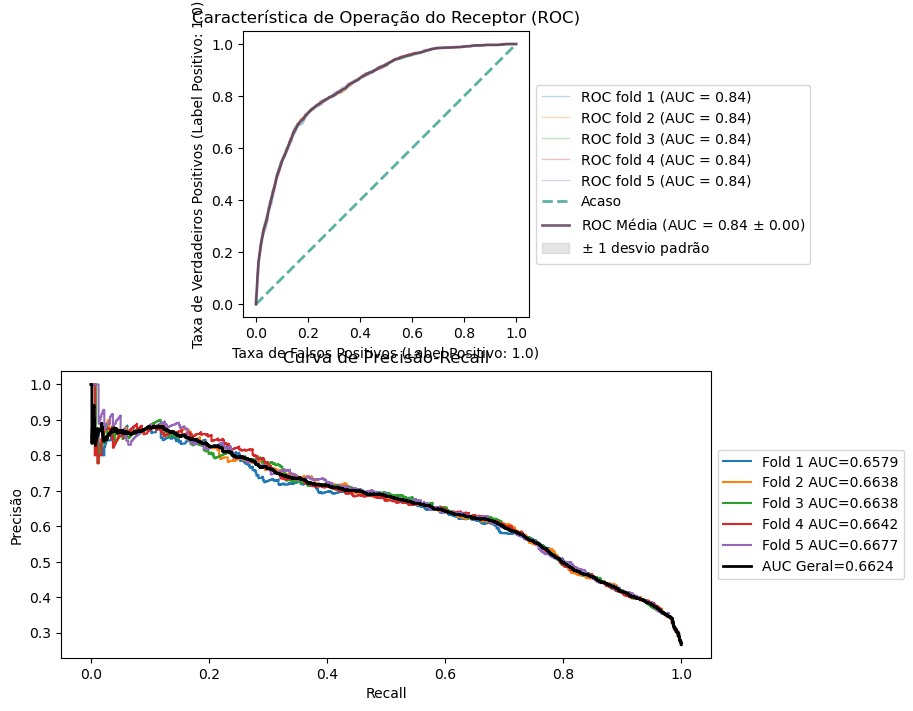

In [92]:
results, model = treino2(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, k_fold=True, k=5, importance=False, save=False)


In [93]:
results

Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  media  Desvio
accuracy     0.79    0.80    0.79    0.80    0.79   0.79    0.00
precision    0.58    0.60    0.60    0.60    0.59   0.59    0.01
recall       0.69    0.72    0.70    0.71    0.71   0.71    0.01
f1_score     0.63    0.65    0.64    0.65    0.64   0.64    0.01

In [94]:
predicted_proba = model.predict_proba(X_test)[:,1]
y_pred = np.where(predicted_proba > 0.4, 1, 0)
#y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Ativo', 'Pediu demissão']))


                precision    recall  f1-score   support

         Ativo       0.90      0.73      0.81      1704
Pediu demissão       0.51      0.78      0.62       617

      accuracy                           0.74      2321
     macro avg       0.71      0.76      0.71      2321
  weighted avg       0.80      0.74      0.76      2321



In [95]:
metrics, cm = generate_classification_metrics(y_test, y_pred)
metrics

Métrica  Valor
0   Acurácia   0.74
1   Precisão   0.51
2  Revocação   0.78
3   F1-Score   0.62

Text(33.222222222222214, 0.5, 'Valor verdadeiro')

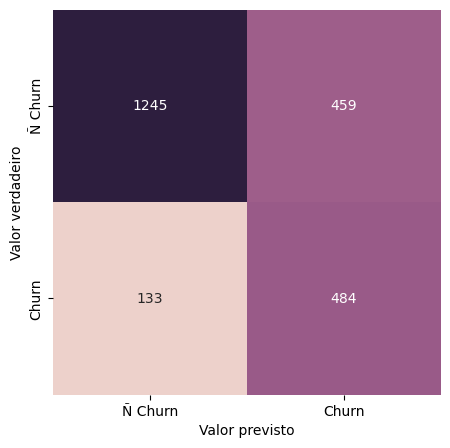

In [96]:
labels = ['Ñ Churn', 'Churn']
plt.figure(figsize=(5, 5))
# Cria o heatmap usando o seaborn
sns.heatmap(cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g', xticklabels=labels, yticklabels=labels, cbar=False, norm=matplotlib.colors.LogNorm())
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')

In [97]:
# Gerar dataset de Resposta

predicoes = pd.Series(model.predict(X_test), name='predicoes', index=index_test)
probabilidades = pd.DataFrame(model.predict_proba(X_test), columns=['P_0', 'P_1'], index=index_test)
resposta = pd.concat([pd.concat([ID_teste, y_test], axis=1), pd.concat([predicoes, probabilidades], axis=1)], axis=1)

##### 3.4.3 - Feature Importance

Text(0.5, 1.0, 'Feature Importance')

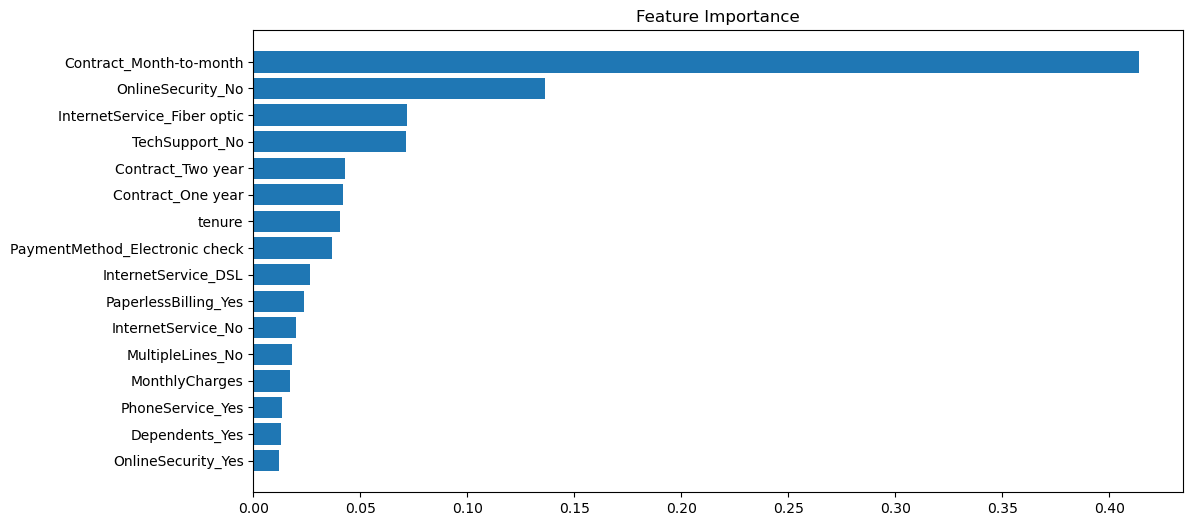

In [98]:
# gerar feature importance 

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


### 4. Explicabilidade SHAP

In [99]:
# executar o explainer do shap
explainer = shap.TreeExplainer(model)


In [100]:
# gerar os valores de shap para o treino para plotar os graficos

shap_values_train = explainer.shap_values(X_train, y_train)


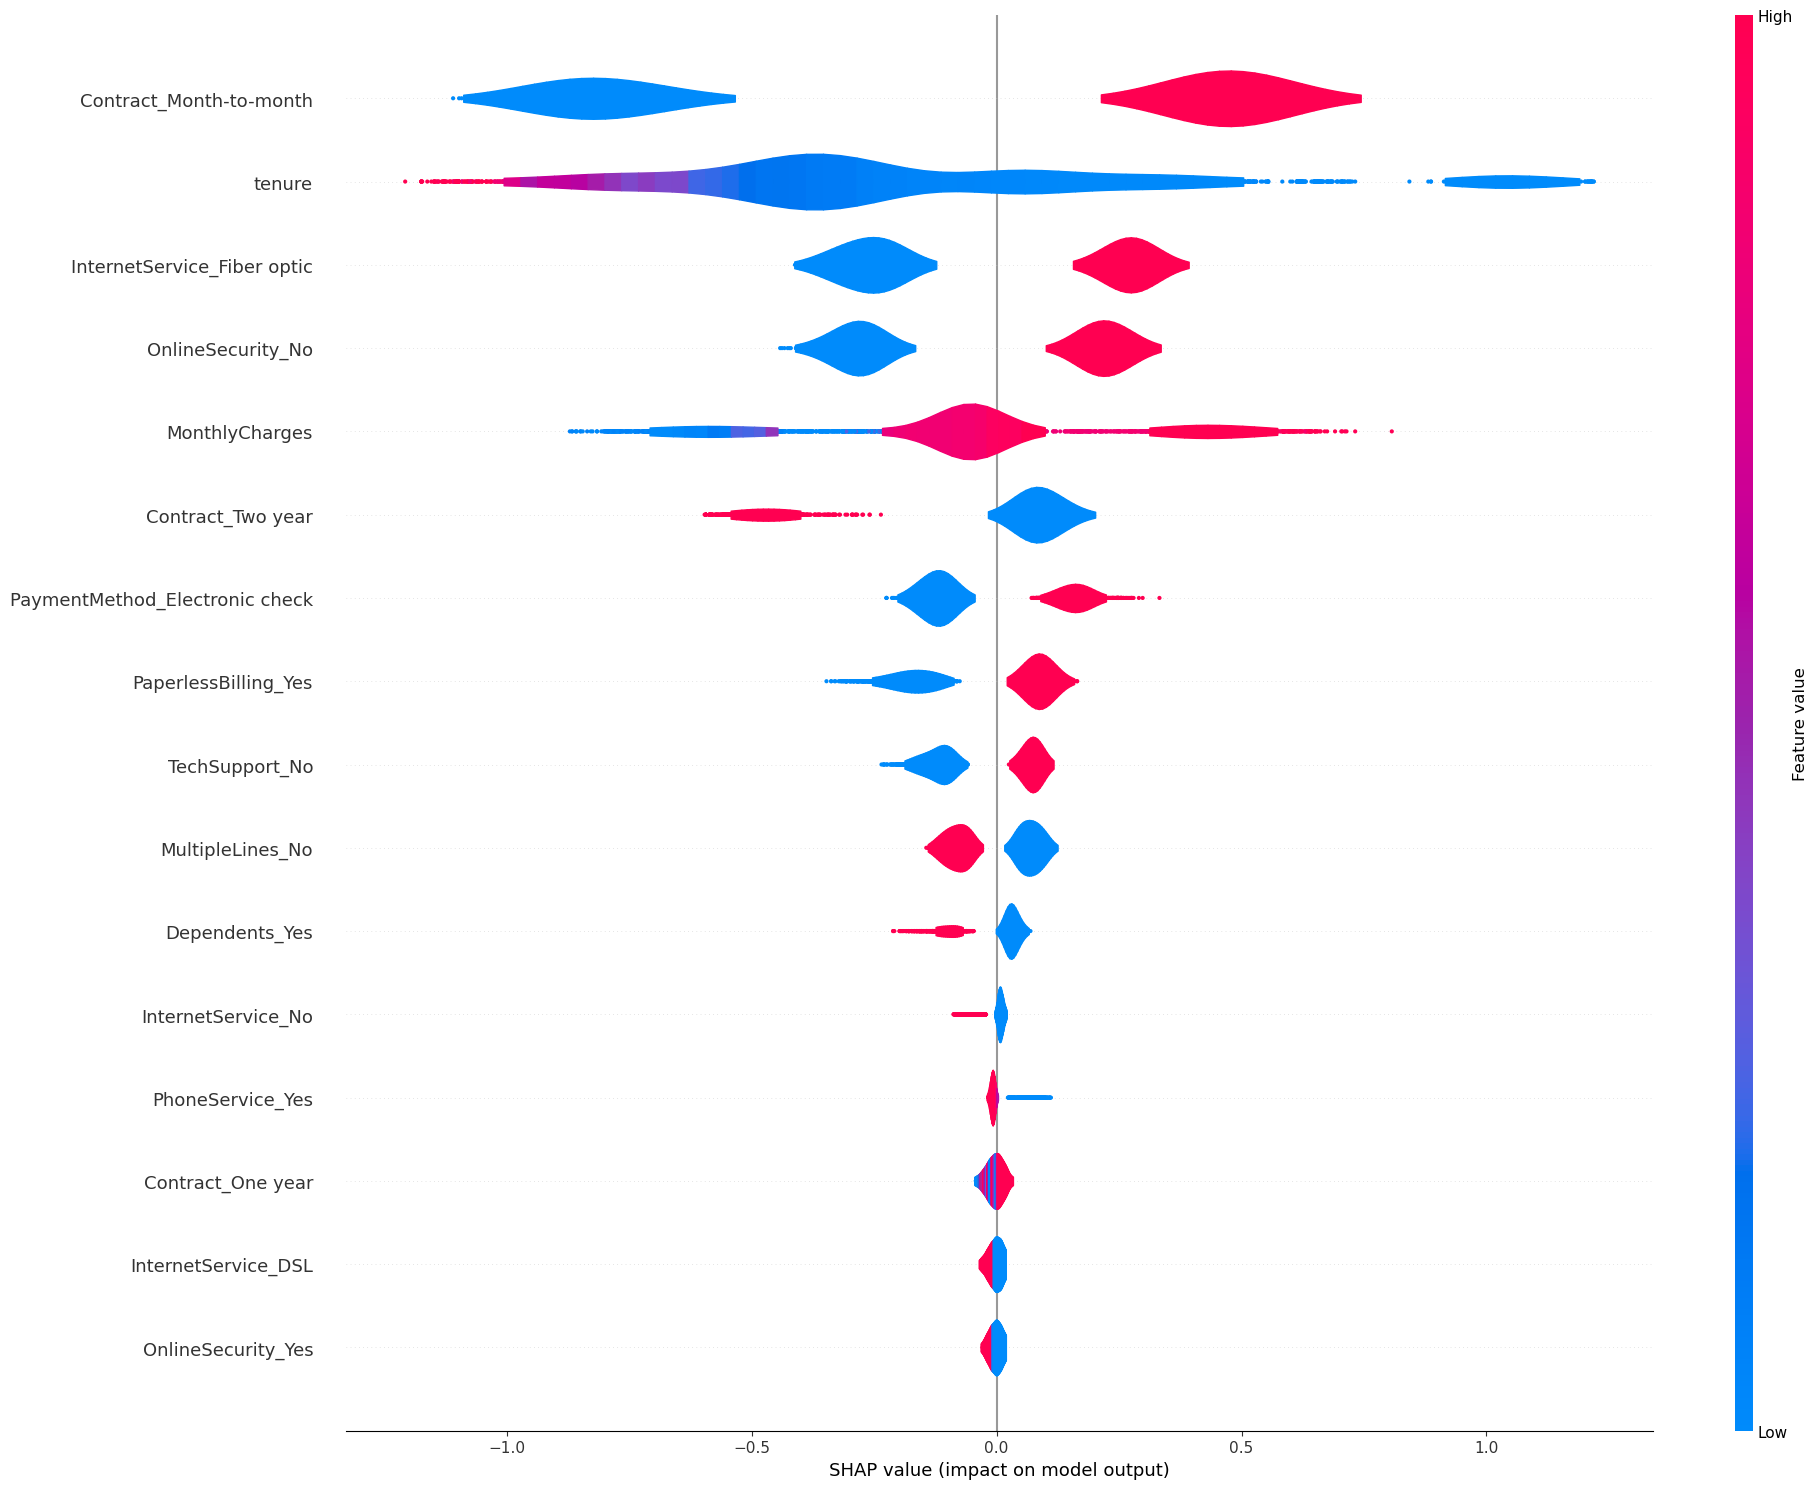

In [101]:
# Gráfico 1 - Contribução das variáveis violino
shap.summary_plot(shap_values_train, X_train, plot_size=(20,15), plot_type="violin")

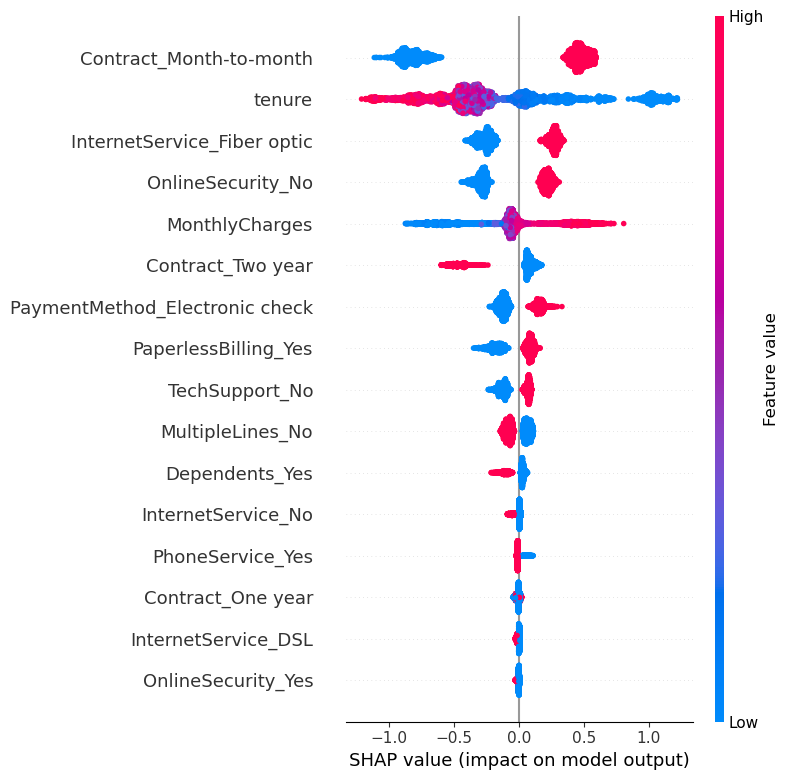

In [102]:
# Grafico de contribuição scatter
shap.summary_plot(shap_values_train, X_train, show=True)

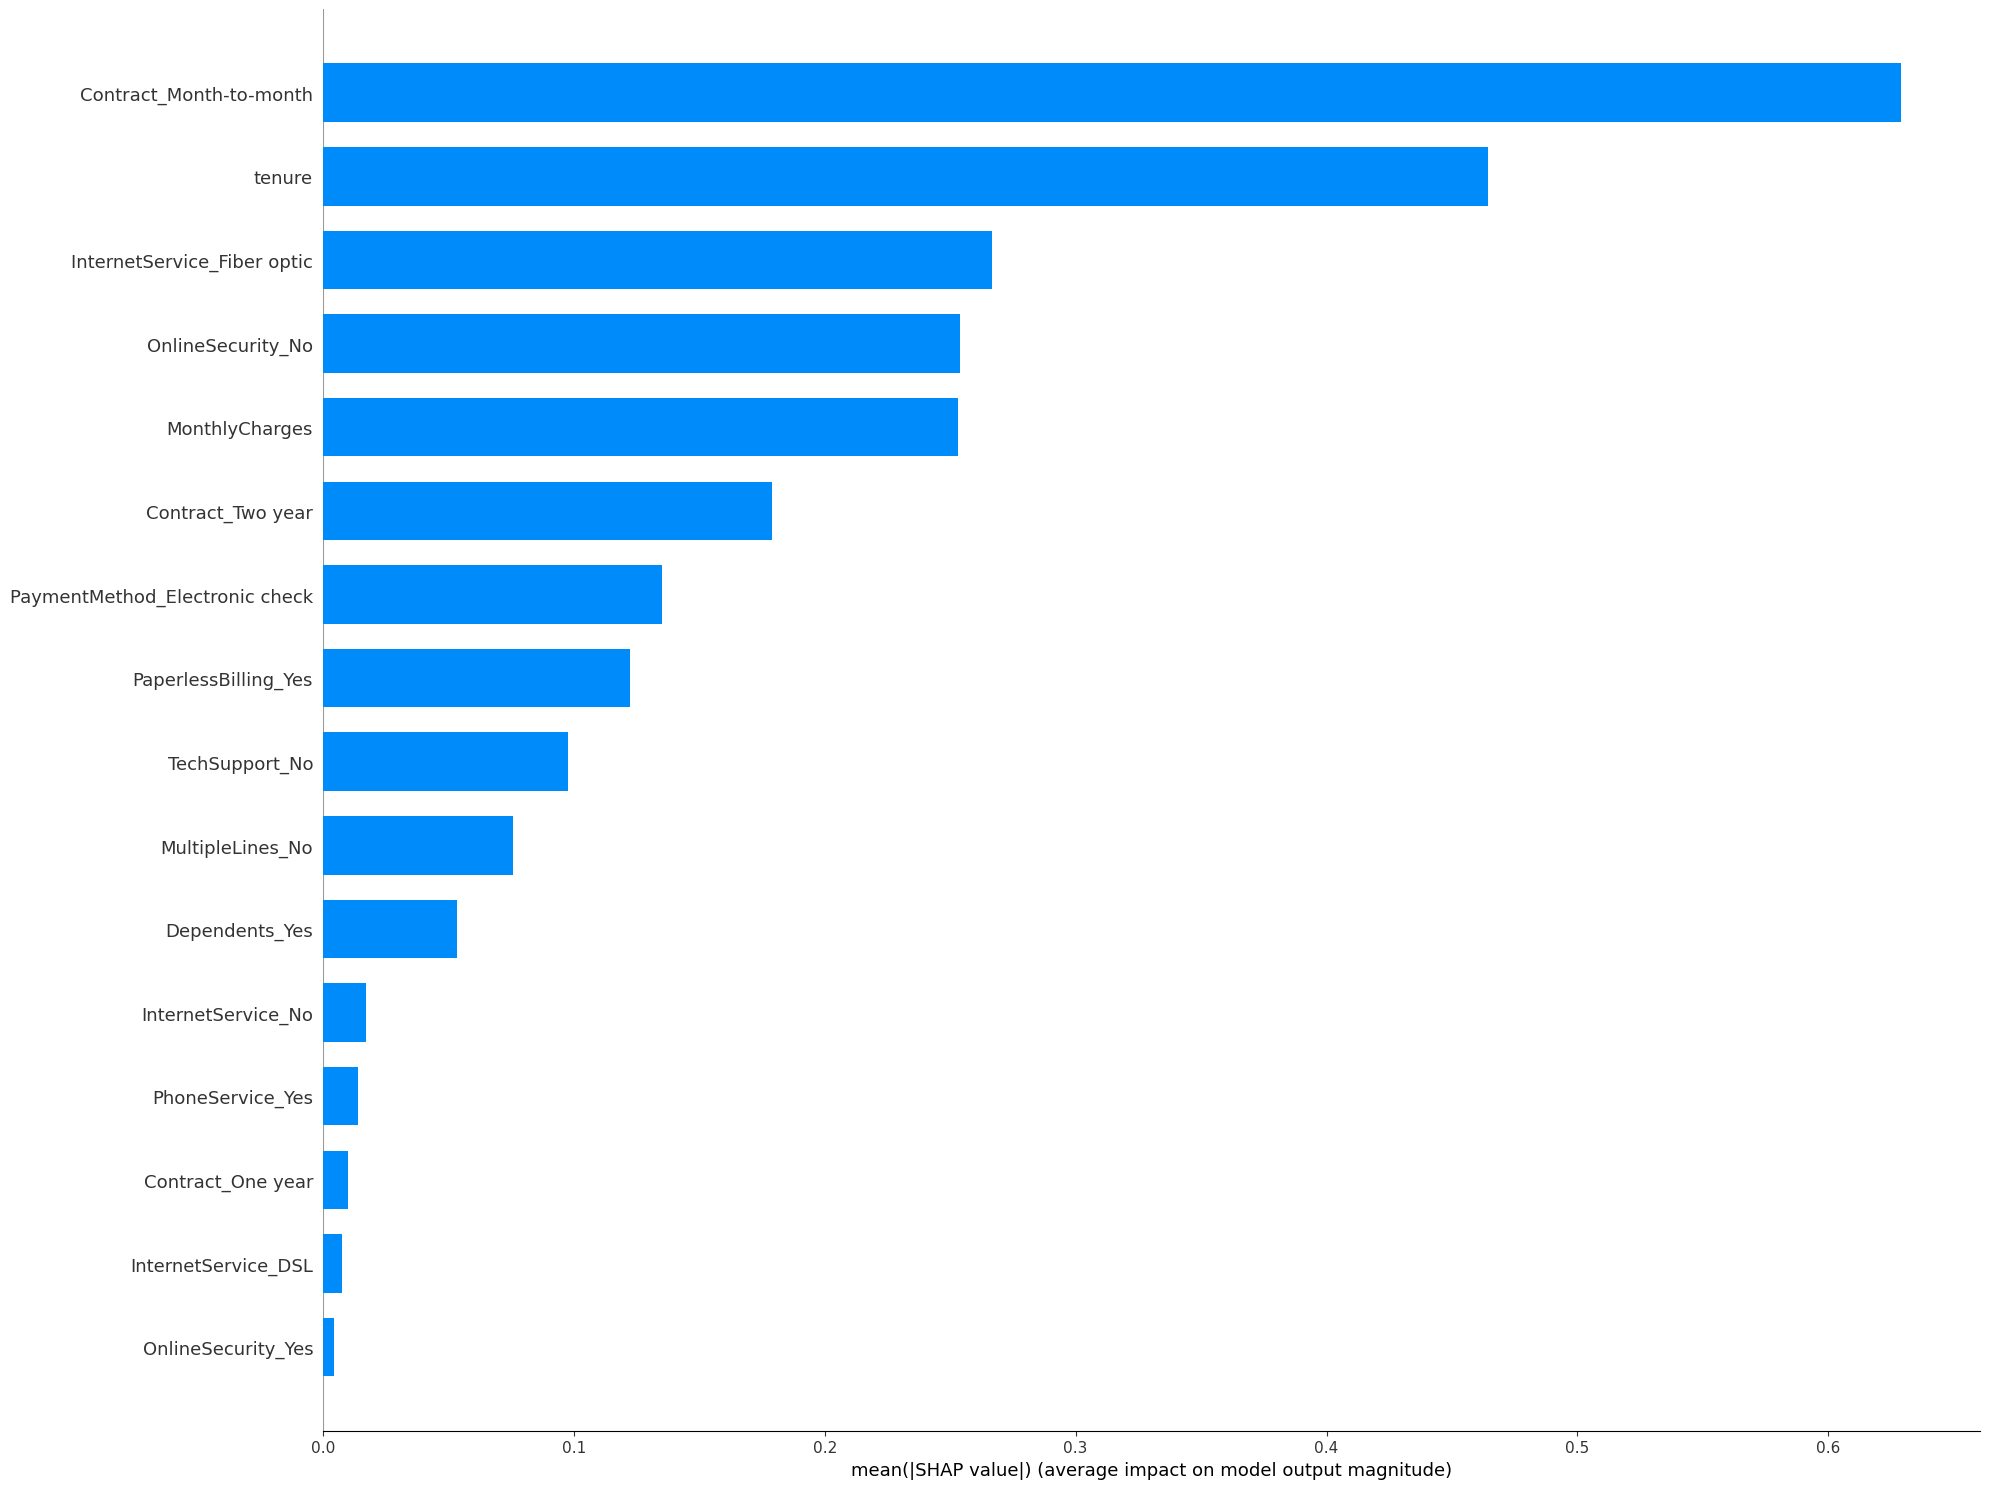

In [103]:
# grafico de barras das contribuições das variáveis 
shap.summary_plot(shap_values_train, X_train, plot_type="bar", plot_size=(20,15));

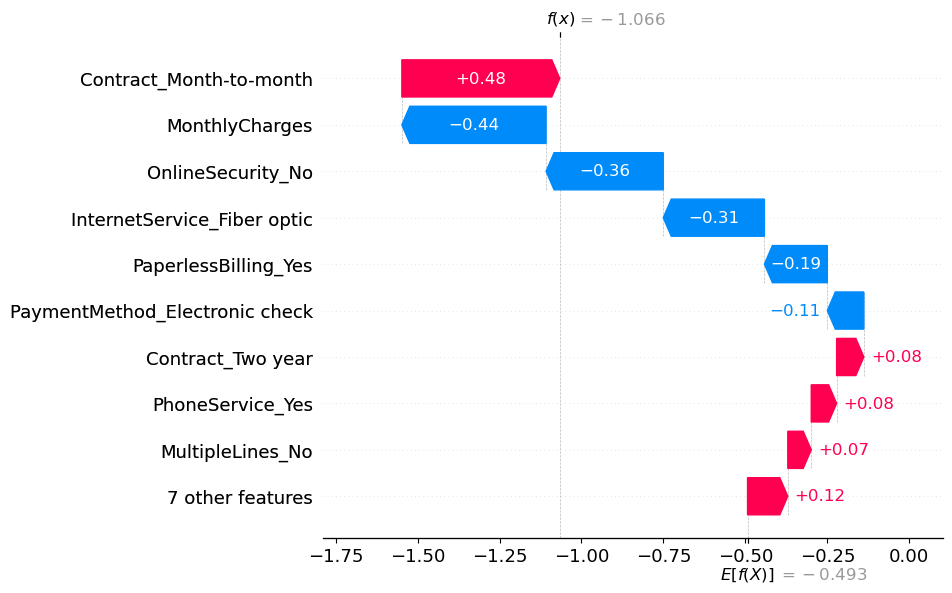

In [104]:
# é possível gerar esse gráfico para cada ID, são as contribuições individuais de cada variável para cada ID
shap.plots._waterfall.waterfall_legacy(expected_value=explainer.expected_value, shap_values=shap_values_train[333].reshape(-1), feature_names=X_train.columns, show=True)

In [105]:
# gerando para teste 

shap_values_test = explainer.shap_values(X_test, y_test)

In [106]:
shap_teste = pd.DataFrame(shap_values_test, columns=X_test.columns, index=index_test)

In [107]:
#criando dataset de efeitos
dataset_efeitos = pd.merge(resposta, shap_teste, right_index=True, left_index=True)

In [108]:
# Para uma comparação simples podemos ver os principais efeitos a ser abordados para os 250 ids com maior probabilidade
efeito_250 = dataset_efeitos.sort_values(by='P_1', ascending=False).head(250).drop(['customerID', 'Churn_Yes', 'predicoes', 'P_0','P_1'], axis=1).mean().sort_values(ascending=False).reset_index()
efeito_250.rename(columns={0:'Efeito', 'index':'Variável'}, inplace=True)

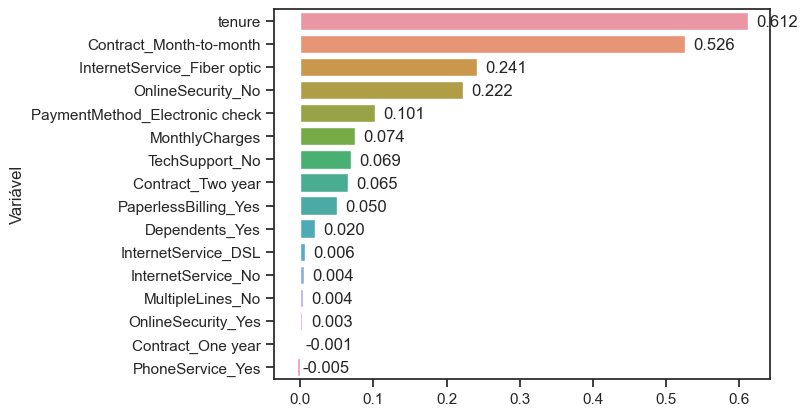

In [148]:
# Create barplot
ax = sns.barplot(data=efeito_250.set_index('Variável').T, orient='h') 
# Annotate every single Bar with its value, based on it's width           
for p in ax.patches:
    width = p.get_width()
    plt.text(0.04+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.3f}'.format(width),
             ha='center', va='center')

Text(0.5, 1.0, 'Histograma de Predições')

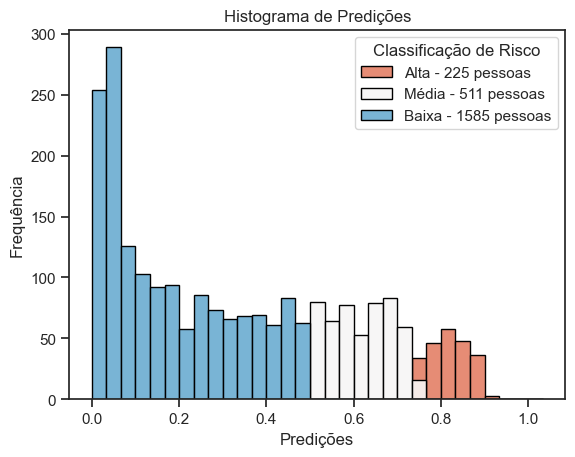

In [110]:
# criando um gráfico de faixa de risco 50 75% para apresentação, fica uma visualização interessante
dataset_efeitos['class_risco'] = dataset_efeitos['P_1'].apply(lambda x: 'Baixa' if x < 0.50 else 'Média' if (x >= 0.50) & (x < 0.75) else 'Alta')
dataset_efeitos = dataset_efeitos.sort_values('P_1')

try:
    alta = dataset_efeitos.class_risco.value_counts()['Alta']

except:
    alta = 0

try:
    media = dataset_efeitos.class_risco.value_counts()['Média']

except:
    media = 0

try:
    baixa = dataset_efeitos.class_risco.value_counts()['Baixa']

except:
    baixa = 0

sns.set(style="ticks")

# Criando o histograma
hist_plot = sns.histplot(dataset_efeitos, bins=list(np.arange(0, 1+1/30, 1/30)), x='P_1', hue='class_risco', alpha=0.9, palette='RdBu_r', edgecolor='black')

hist_plot.legend(labels=[f'Alta - {alta} pessoas', f'Média - {media} pessoas', f'Baixa - {baixa} pessoas'], title='Classificação de Risco')

plt.xlabel("Predições")
plt.ylabel("Frequência")
plt.title('Histograma de Predições')


### 5 - Impacto de ações

In [111]:
# Primeiro vamos verificar o impacto de conversão de 30% dos contratos mensais em 2 anos
# vamos aolhar apenas para as pessoas com Churn e fazer uma selação aleatória em teste

In [112]:
X_teste_impacto = (df_encoded.set_index(df.dropna().index)).loc[index_test, :]

In [113]:
# Identificar instâncias na classe 1 (Contract_Month-to-month) que tem churn positivo
instancias_classe_1 = X_teste_impacto[(X_teste_impacto['Contract_Month-to-month'] == 1)&(X_teste_impacto['Churn_Yes'] == 1)]

# Calcular o número de instâncias a serem alteradas (30%)
num_instancias_a_alterar = int(len(instancias_classe_1) * 0.3)

# Selecionar aleatoriamente o número necessário de instâncias para alterar
instancias_a_alterar = instancias_classe_1.sample(n=num_instancias_a_alterar)


X_teste_impacto.loc[instancias_a_alterar.index, 'Contract_Month-to-month'] = 0
X_teste_impacto.loc[instancias_a_alterar.index, 'Contract_Two year'] = 1

In [114]:
X_teste_impacto[['Contract_Two year','Contract_One year','Contract_Month-to-month']].sum(axis=1).sum()

2321.0

In [115]:
X_teste_impacto.drop(['OnlineSecurity_No internet service',
                                'OnlineBackup_No internet service',
                                'DeviceProtection_No internet service',
                                'TechSupport_No internet service',
                                'StreamingTV_No internet service',
                                'StreamingMovies_No internet service','TotalCharges', 'customerID', 'Churn_Yes'], axis=1, inplace=True)

In [116]:
# Primeiro Vamos normalizar ou padronizar os dados

X_teste_impacto = scaler.transform(X_teste_impacto)

X_teste_impacto = pd.DataFrame(X_teste_impacto, columns=columns, index=index_test)

In [117]:
X_teste_impacto = X_teste_impacto.loc[:,selected_features]

In [118]:
## Predizendo as probabilidades
predicted_proba = model.predict_proba(X_teste_impacto)

In [119]:
# Juntando com a tabela de resposta criada anteriormente que tem IDs, probabilidades e flags
data_impacto_1 = pd.concat([resposta.loc[instancias_a_alterar.index,:], pd.DataFrame(predicted_proba, index=index_test).loc[instancias_a_alterar.index,:]], axis=1)

In [120]:
# temos 161 pessoas afetadas
data_impacto_1.shape

(161, 7)

In [121]:
# com uma redução média de 32% na probabilidade
(data_impacto_1['P_1']-data_impacto_1[1]).mean()

0.39076808

In [122]:
# chegando até 47%
(data_impacto_1['P_1']-data_impacto_1[1]).max()

0.56310964

In [123]:
## Agora da mesma forma vamos considerar as pessoas recebendo suporte
# nesse caso vamos considerar uma melhoria de serviço de 50%

In [124]:
X_teste_impacto = (df_encoded.set_index(df.dropna().index)).loc[index_test, :]

In [125]:
# Identificar instâncias na classe 1 (Contract_Month-to-month) que tem churn positivo
instancias_classe_1 = X_teste_impacto[(X_teste_impacto['TechSupport_No'] == 1)&(X_teste_impacto['Churn_Yes'] == 1)]

# Calcular o número de instâncias a serem alteradas (50%)
num_instancias_a_alterar = int(len(instancias_classe_1) * 0.5)

# Selecionar aleatoriamente o número necessário de instâncias para alterar
instancias_a_alterar = instancias_classe_1.sample(n=num_instancias_a_alterar)


X_teste_impacto.loc[instancias_a_alterar.index, 'TechSupport_No'] = 0
X_teste_impacto.loc[instancias_a_alterar.index, 'TechSupport_Yes'] = 1

In [126]:
X_teste_impacto[['TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes']].sum(axis=1).sum()

2321.0

In [127]:
X_teste_impacto.drop(['OnlineSecurity_No internet service',
                                'OnlineBackup_No internet service',
                                'DeviceProtection_No internet service',
                                'TechSupport_No internet service',
                                'StreamingTV_No internet service',
                                'StreamingMovies_No internet service','TotalCharges', 'customerID', 'Churn_Yes'], axis=1, inplace=True)

In [128]:
# Primeiro Vamos normalizar ou padronizar os dados

X_teste_impacto = scaler.transform(X_teste_impacto)

X_teste_impacto = pd.DataFrame(X_teste_impacto, columns=columns, index=index_test)

In [129]:
X_teste_impacto = X_teste_impacto.loc[:,selected_features]

In [130]:
## Predizendo as probabilidades
predicted_proba = model.predict_proba(X_teste_impacto)

In [131]:
# Juntando com a tabela de resposta criada anteriormente que tem IDs, probabilidades e flags
data_impacto_1 = pd.concat([resposta.loc[instancias_a_alterar.index,:], pd.DataFrame(predicted_proba, index=index_test).loc[instancias_a_alterar.index,:]], axis=1)

In [132]:
# temos 161 pessoas afetadas
data_impacto_1.shape

(240, 7)

In [133]:
# com uma redução média de 5% na probabilidade
(data_impacto_1['P_1']-data_impacto_1[1]).mean()

0.052555345

In [134]:
# chegando até 11%
(data_impacto_1['P_1']-data_impacto_1[1]).max()

0.11220628

In [ ]:
# Nesse teste optei por não montar pipelines ou utilizar NNs devido ao tempo disponível